In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates
from datetime import datetime
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
import math

from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy
%matplotlib inline

!pip install linearmodels
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.datasets import jobtraining

df = pd.read_csv('Walmart_Store_sales.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

!pip install pmdarima
import pmdarima as pm
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pandas.tseries.frequencies import to_offset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.4 MB/s 
     |████████████████████████████████| 9.9 MB 45.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


## **Description of the Data**

Walmart, one of the top retail chains in the US, wants to estimate sales and profits for earnings forecasts, which is of concern to investors and stakeholders. Fluctuations in demand is a hurdle for the company make sales projections unstable, especially in an unpredictable macro climate.

This dataset includes historical weekly sales data for 45 Walmart locations nationwide in various geographies. The primary objective of this project is to forecast department-wide weekly sales for Walmart across all its locations in response to changes in variables that appear to be outside the company's control, such as temperature, gasoline prices, holidays, the unemployment rate, and shifts in consumer price indices. Consumer spending is reportedly impacted by weather/temperature patterns (Parsons, 2001), fuel/commodity costs (Hastings and Shapiro, 2012), and unemployment (Ganong, 2016), according to a number of study articles.
 
This archival data covers sales from 2010-02-05 to 2012-11-01. The following fields can be found in this file:
 
Store: the store number
 
Date: the week of sales
 
Weekly_Sales: weekly sales for the given store
 
Holiday_Flag: whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
 
Temperature: temperature on the day of sale
 
Fuel_Price: cost of fuel in the region
 
CPI: prevailing consumer price index
 
Unemployment: prevailing unemployment rate

In [ ]:
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


## **Exploratory Data Analysis & Visualizations**

First, let's explore the quality of the data.

In [ ]:
# checking the type and number of each variable present in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


This dataset consists of continous, categroical, and binary variables 

In [ ]:
# cleaning the data: checking for any null or duplicate values 
df.isnull().sum()
df.duplicated().any()

False

It appears there are no null values or duplicates across all 6,435 observations.

In [ ]:
# investigating the distribution and summary statistics of the continous variables present in the dataset 
df[["Weekly_Sales", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]].describe()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000



Additionally, it appears as though all of the continuous data (i.e all columns other than store number) have reasonable-appearing distributions with no obvious outliers.

Next, we can look at the time series for both the response variable (Weekly Sales) and our predictors.


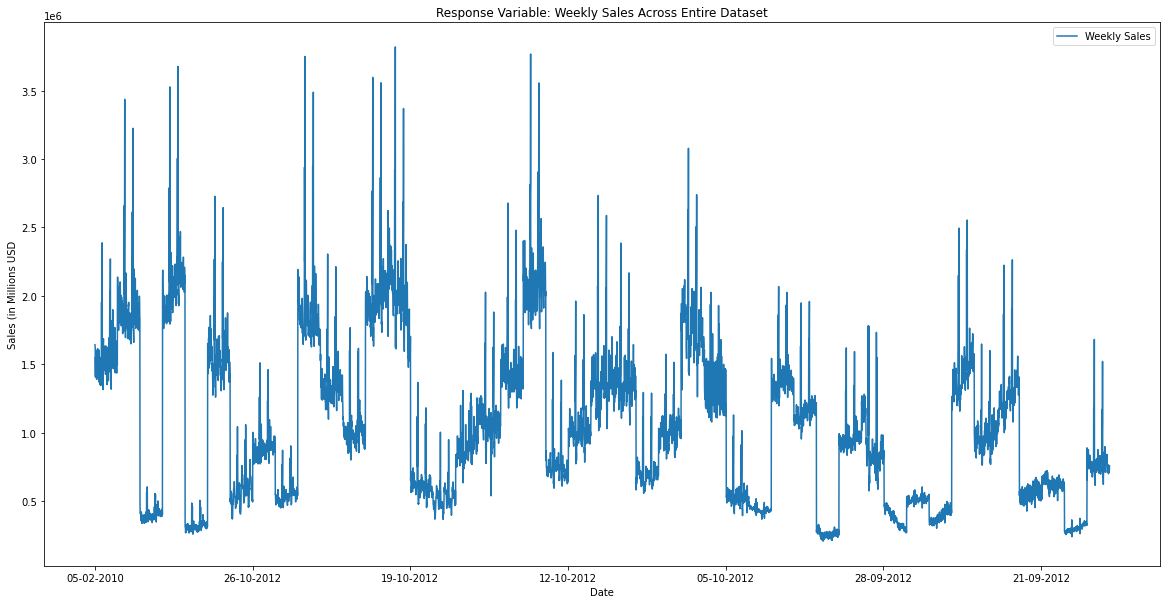

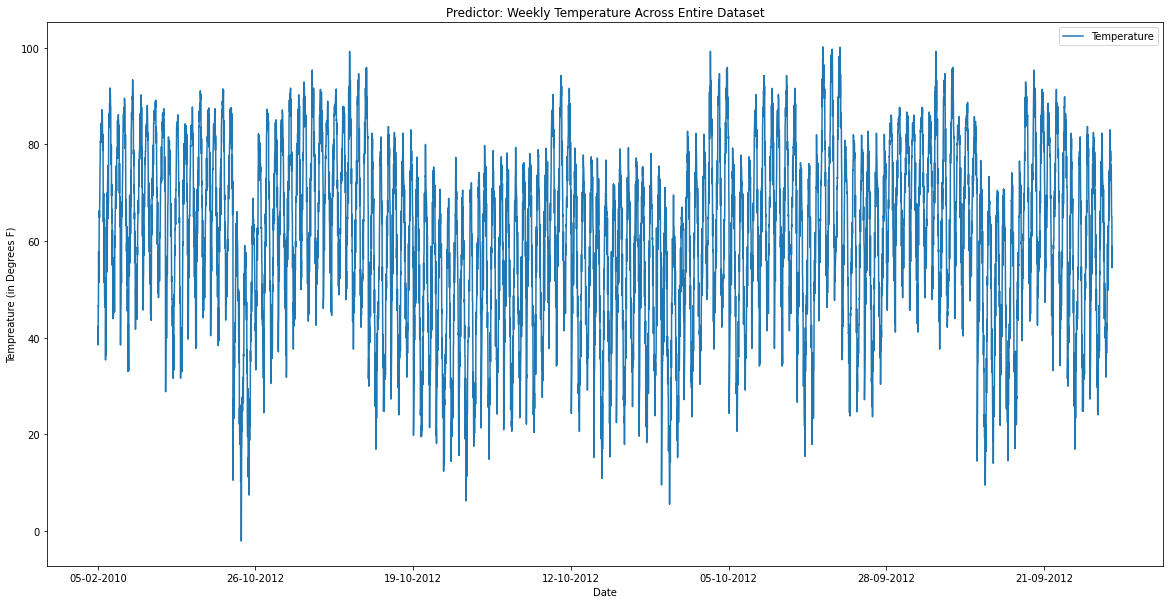

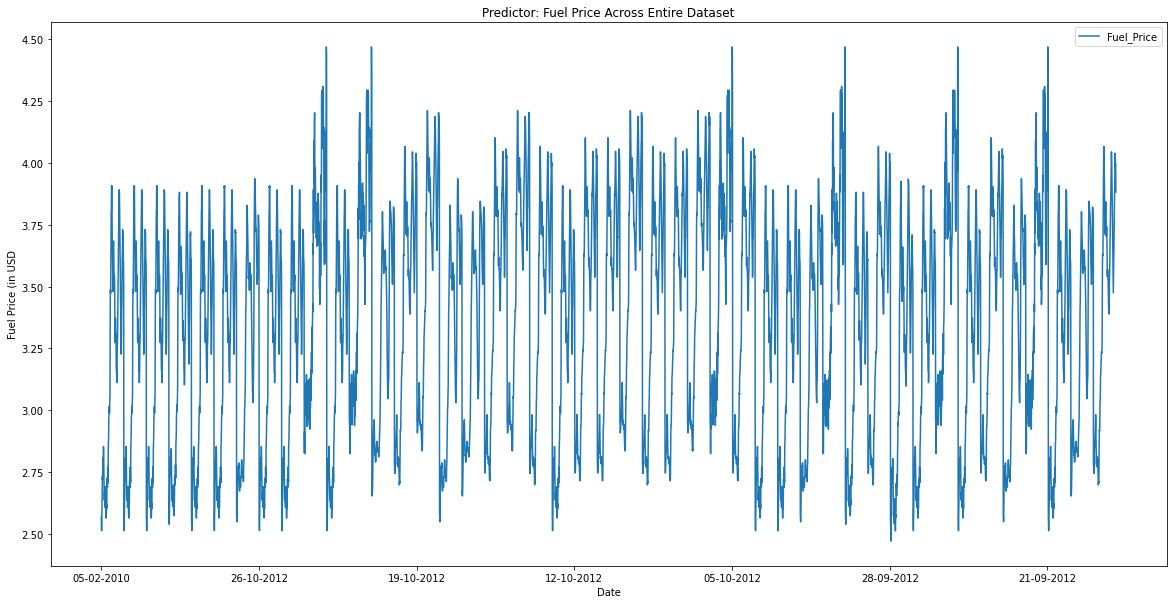

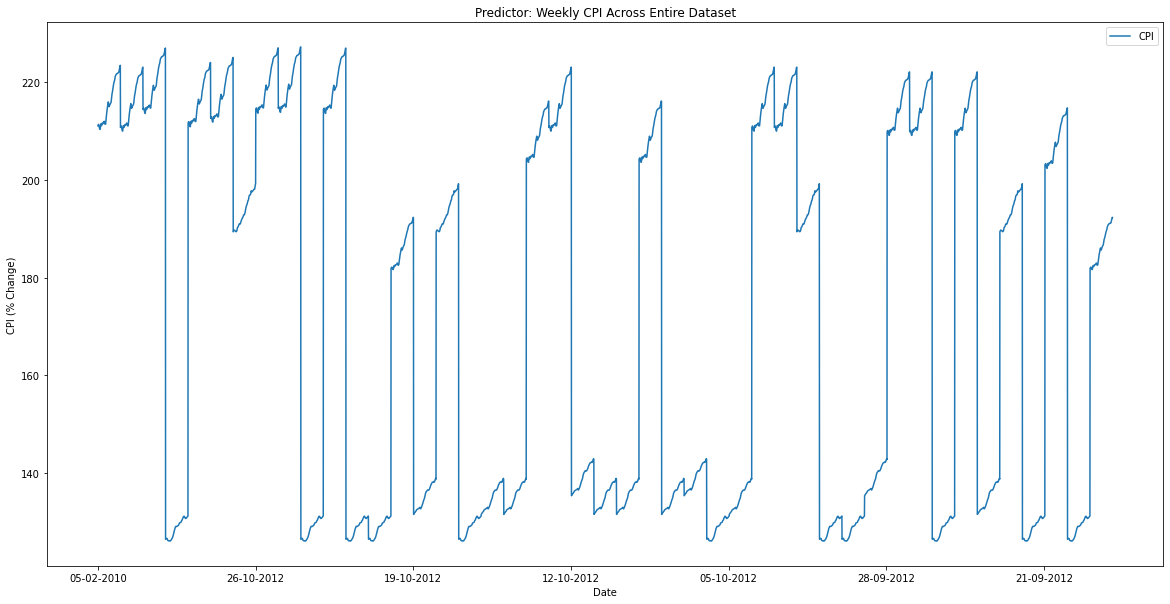

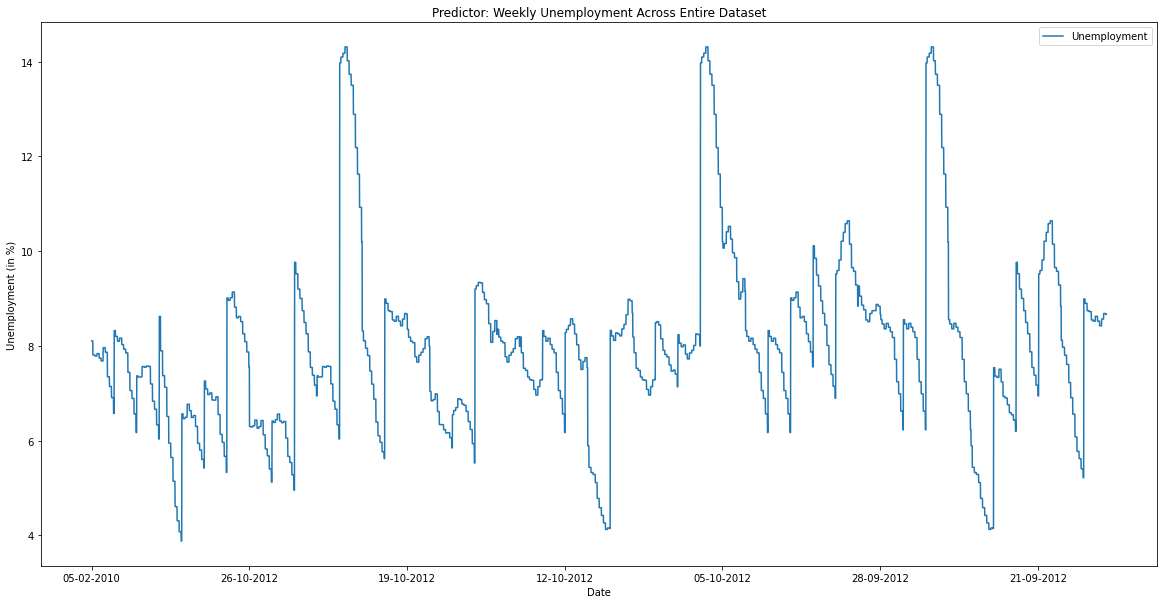

In [ ]:
df.plot("Date", "Weekly_Sales", figsize = (20,10))
plt.legend(labels = ["Weekly Sales"])
plt.ylabel("Sales (in Millions USD")
plt.title("Response Variable: Weekly Sales Across Entire Dataset");

df.plot("Date", "Temperature", figsize = (20,10))
plt.ylabel("Tempreature (in Degrees F)")
plt.title("Predictor: Weekly Temperature Across Entire Dataset");

df.plot("Date", "Fuel_Price", figsize = (20,10))
plt.legend(labels = ["Fuel_Price"])
plt.ylabel("Fuel Price (in USD")
plt.title("Predictor: Fuel Price Across Entire Dataset");

df.plot("Date", "CPI", figsize = (20,10))
plt.ylabel("CPI (% Change)")
plt.title("Predictor: Weekly CPI Across Entire Dataset");

df.plot("Date", "Unemployment", figsize = (20,10))
plt.ylabel("Unemployment (in %)")
plt.title("Predictor: Weekly Unemployment Across Entire Dataset");

On first glance, there are no obvious trends in these variables, implying that they are stationary, though we should do a deeper test, particularly into weekly retail sales (done below, in the baseline model section of this notebook). 

Next, let's look at how the predictors and response variable all relate to one another.

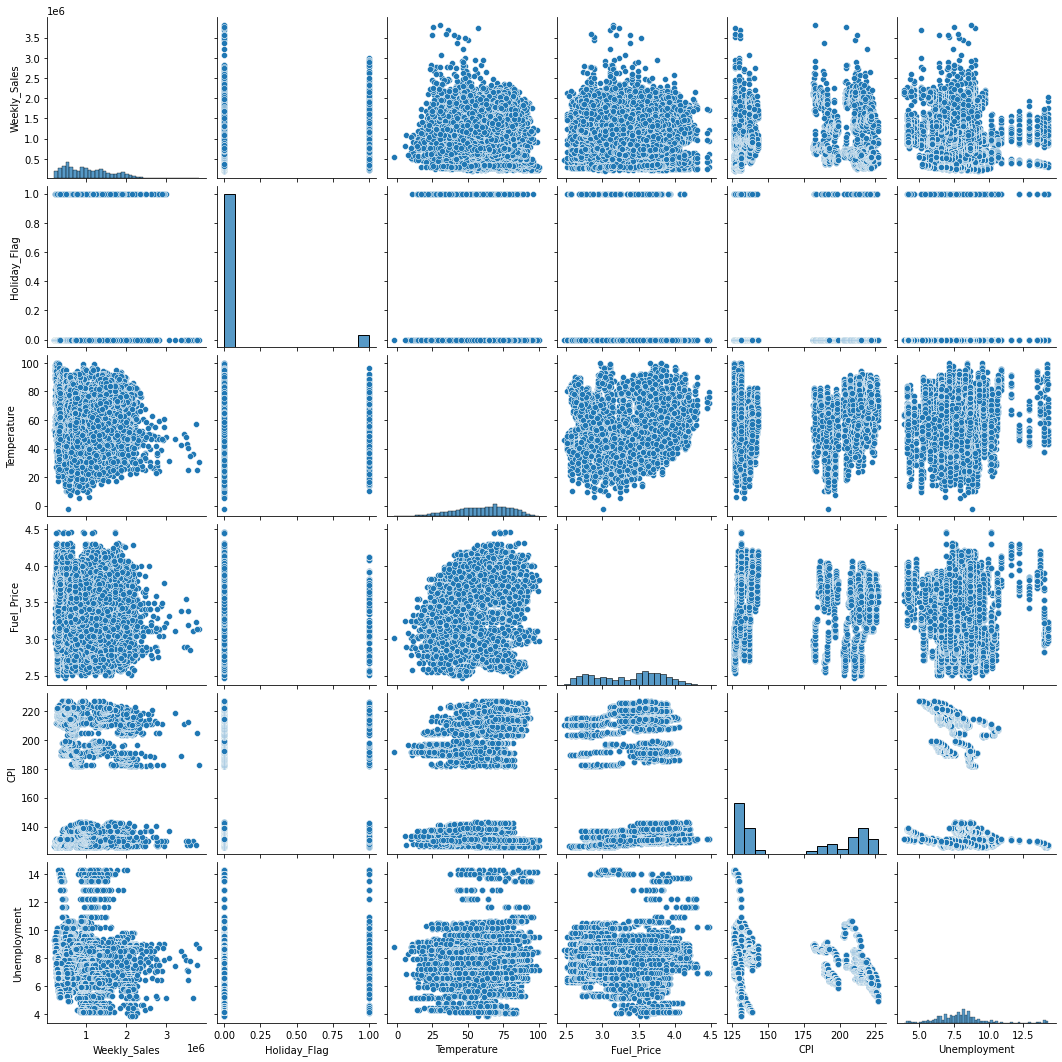

In [ ]:
sns.pairplot(df.drop(['Store', 'Date'], axis = 1))

In [ ]:
df.drop(['Date', 'Store'], axis = 1).corr()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Weekly_Sales,1.000000,0.036891,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,0.036891,1.000000,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-0.063810,-0.155091,1.000000,0.144982,0.176888,0.101158
Fuel_Price,0.009464,-0.078347,0.144982,1.000000,-0.170642,-0.034684
CPI,-0.072634,-0.002162,0.176888,-0.170642,1.000000,-0.302020
Unemployment,-0.106176,0.010960,0.101158,-0.034684,-0.302020,1.000000


At first glance, all of the macroeconomic indicators don't seem to be correlated with weekly sales in a meaningful way.

As a final path of initial investigation, let's look at sales performance across stores and see if there are any insights to be gained from that distribution.

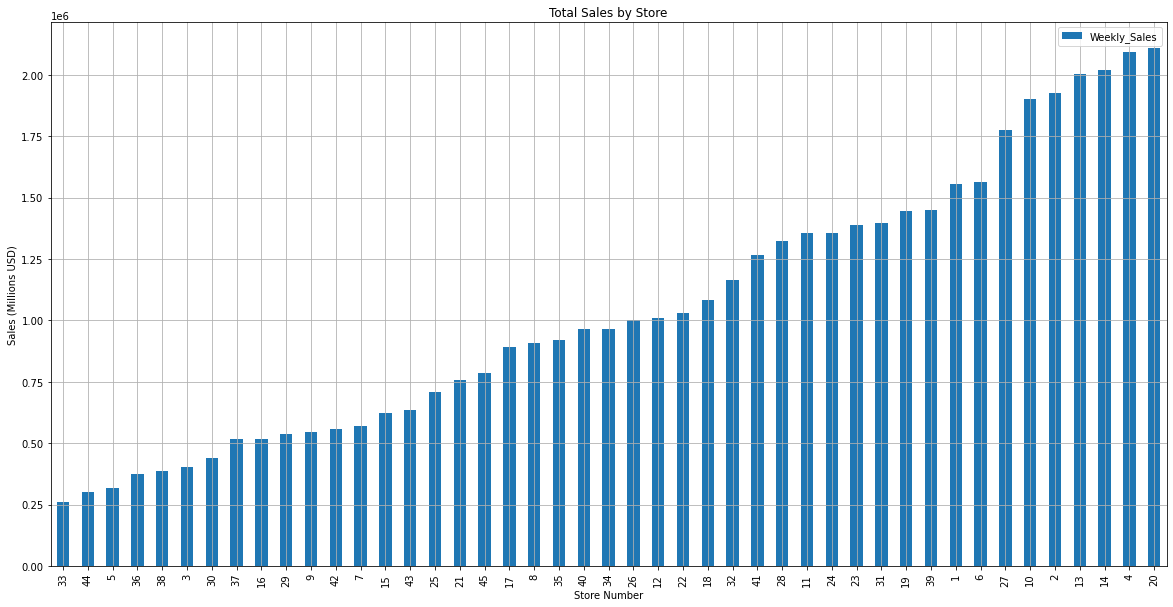

In [ ]:
store_avgs = df.groupby(["Store"]).mean().reset_index().sort_values(by=['Weekly_Sales'])
store_avgs.plot.bar("Store", "Weekly_Sales", figsize = (20, 10))
plt.title("Total Sales by Store")
plt.ylabel("Sales (Millions USD)")
plt.xlabel("Store Number")
plt.grid()
plt.show()

There does seem to a wide disparity in the average sales across the 45 stores in the dataset, with the best-performing store having almost 10 times as many sales as the lowest-performing.

## **Project Question**

To what extent can we predict Walmart's average weekly sales across 45 stores from macroeconomic and external factors? 

## **Baseline Model**

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
weekly_df = df.resample('W').mean() 
weekly_df.index = weekly_df.index + to_offset('-2D')
weekly_df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,23.0,1.105572e+06,0.0,34.037333,2.717844,167.730885,8.619311
2010-02-12,23.0,1.074148e+06,1.0,34.151333,2.694022,167.825608,8.619311
2010-02-19,23.0,1.072822e+06,0.0,37.719778,2.672067,167.871686,8.619311
2010-02-26,23.0,9.770794e+05,0.0,39.243556,2.683933,167.909657,8.619311
2010-03-05,23.0,1.041588e+06,0.0,42.917333,2.731200,167.947628,8.619311


In [ ]:
def test_stationarity(df):
    
    rolling_mean = df.rolling(4).mean()
    rolling_std = df.rolling(4).std()
    
    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(df, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")
    ax.set_xticks(df.index[::10])
    ax.set_xticklabels(df.index[::10], rotation=30)
    plt.ylabel('Weekly Sales')
    plt.title("Time Series, Rolling Mean, Standard Deviation")
    plt.legend(loc="best")
    
    # Augmented Dickey-Fuller test 
    adft = adfuller(df,autolag='AIC')

    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  ,
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    return print(output_df)

#### Stationarity Test

         Values                       Metric
0 -5.908298e+00              Test Statistics
1  2.675979e-07                      p-value
2  4.000000e+00             No. of lags used
3  1.380000e+02  Number of observations used
4 -3.478648e+00          critical value (1%)
5 -2.882722e+00          critical value (5%)
6 -2.578065e+00         critical value (10%)


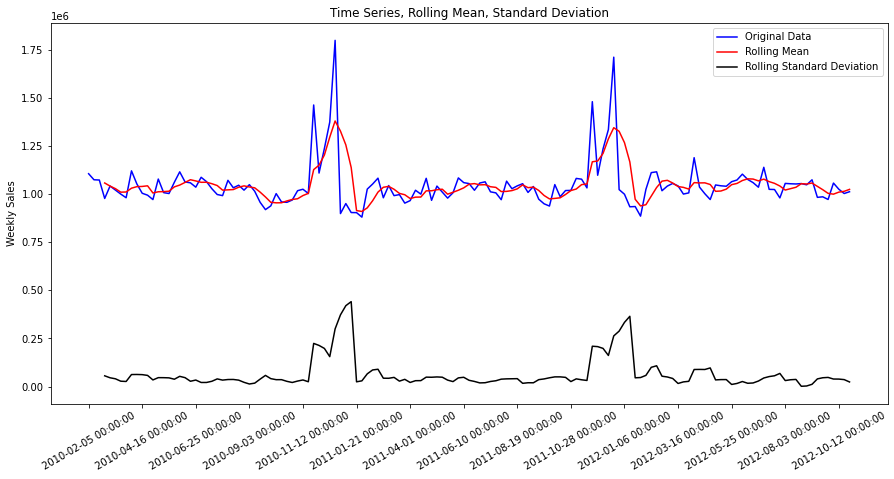

In [ ]:
test_stationarity(weekly_df[['Weekly_Sales']])

#### Seasonal Decompose

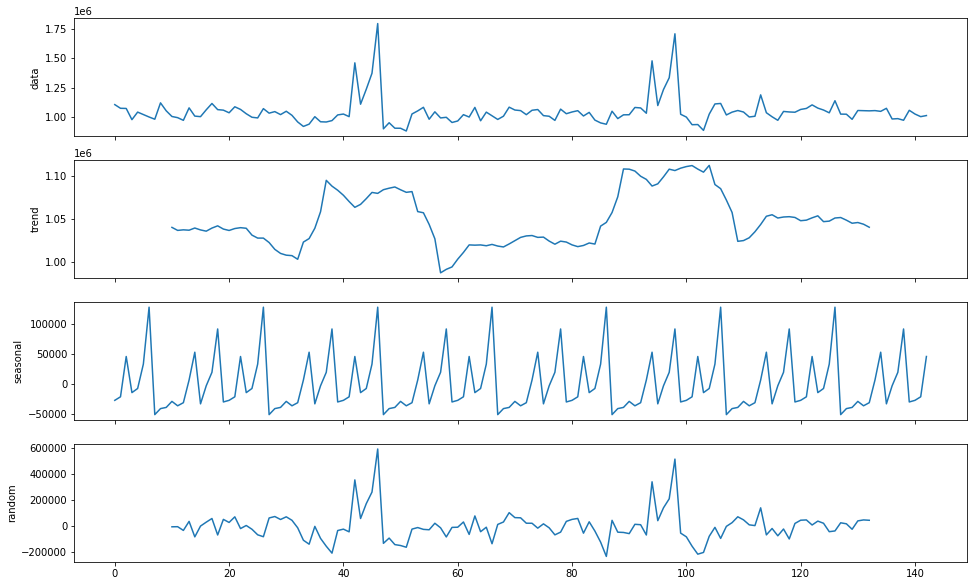

In [ ]:
decomposed = decompose(weekly_df['Weekly_Sales'].values, 'additive', m=20)
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})

Time series does not look stationary even though the p-value for ADF is < 0.05. There is clear seasonality in the data, which makes sense as consumer demand should be cyclical. 

#### Seasonal Differencing

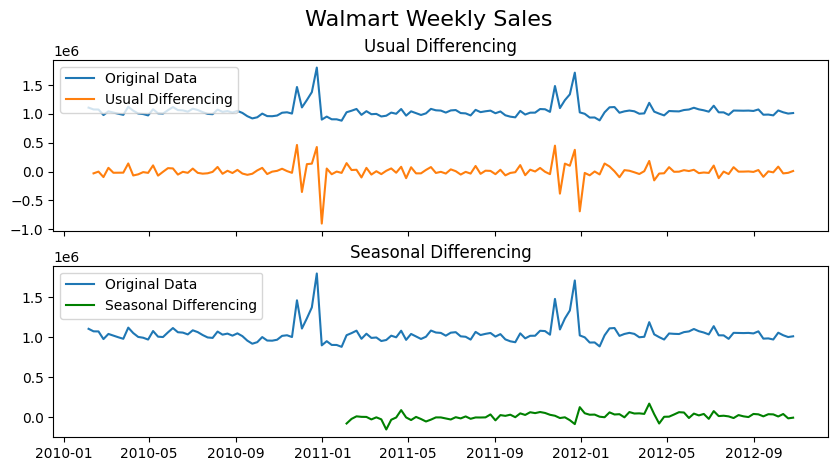

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

axes[0].plot(weekly_df[['Weekly_Sales']][:], label='Original Data')
axes[0].plot(weekly_df[['Weekly_Sales']][:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

axes[1].plot(weekly_df[['Weekly_Sales']][:], label='Original Data')
axes[1].plot(weekly_df[['Weekly_Sales']][:].diff(52), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)

plt.suptitle('Walmart Weekly Sales', fontsize=16)
plt.show()

#### Autocorrelation Plots

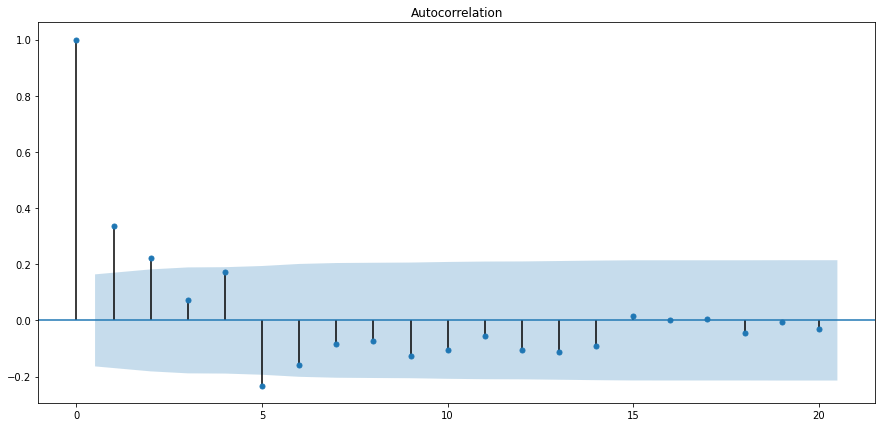

In [ ]:
fig = plot_acf(weekly_df['Weekly_Sales'], lags=20)
fig.set_figheight(7)
fig.set_figwidth(15)

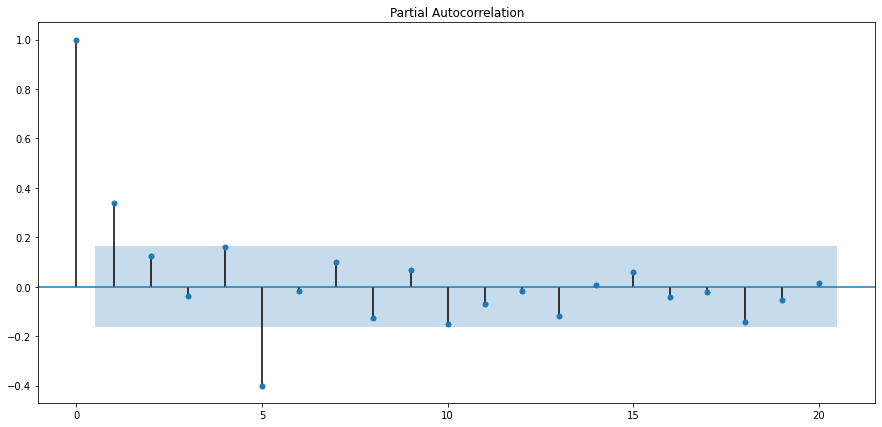

In [ ]:
fig = plot_pacf(weekly_df['Weekly_Sales'], lags=20)
fig.set_figheight(7)
fig.set_figwidth(15)

From the plots above, it seems that there is some degree of autocorrelation in weekly sales for proximate weeks.

For our baseline, we will use annual seasonal patterns to predict Walmart sales - i.e., use Walmart weekly sales one year prior to predict the next year's weekly sales. 

Here we chose to use Mean Average Percentage Error as our error metric. It is 
one of the most popular used error metrics in time series forecasting. It is calculated by taking the mean of the absolute difference between actuals and predicted values divided by the actuals. MAPE is scale-dependent and easily interpretable across many time series models.

In [ ]:
values = weekly_df[['Weekly_Sales']]
baseline_df = pd.concat([values.shift(52), values], axis=1)
baseline_df.columns = ['t-52', 't']

In [ ]:
baseline_train, baseline_test = train_test_split(baseline_df, train_size=0.8, shuffle=False)
X_train, y_train = baseline_train['t-52'], baseline_train['t']
X_test, y_test = baseline_test['t-52'], baseline_test['t']

In [ ]:
baseline_test.head()

,t-52,t
Date,,
2012-04-13,9.994073e+05,1.036206e+06
2012-04-20,1.081704e+06,1.001612e+06
2012-04-27,9.673341e+05,9.714844e+05
2012-05-04,1.041377e+06,1.047204e+06
2012-05-11,1.009914e+06,1.042797e+06


In [ ]:
# Train MAPE
train_predictions = list()
for x in X_train[53:]:
    yhat = x
    train_predictions.append(yhat)
print(f'The train mean absolute percent error of the baseline model is: {mean_absolute_percentage_error(y_train[53:], train_predictions)}')

The train mean absolute percent error of the baseline model is: 0.031124010052185378


In [ ]:
# Test MAPE
predictions = list()
for x in X_test:
    yhat = x
    predictions.append(yhat)
print(f'The test mean absolute error of the baseline model is: {mean_absolute_percentage_error(y_test, predictions)}')

The test mean absolute error of the baseline model is: 0.026531924456735387


In [ ]:
errors = [mean_absolute_percentage_error(y_train[53:], train_predictions), mean_absolute_percentage_error(y_test, predictions)]
types = ['train', 'test']
pd.DataFrame(errors, index=types).rename(columns={0:'MAPE'})

,MAPE
train,0.031124
test,0.026532


Text(0, 0.5, 'Weekly Sales')

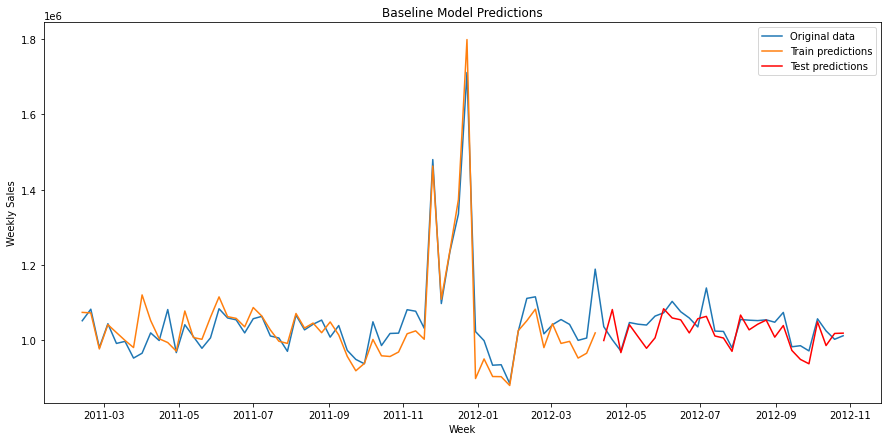

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(baseline_df.index[53:], baseline_df['t'][53:], label='Original data')
plt.plot(baseline_train.index[53:], train_predictions, label='Train predictions')
plt.plot(baseline_test.index, predictions, color='red', label='Test predictions')
plt.title('Baseline Model Predictions')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Weekly Sales')

The baseline model performs decently well, with a test MAPE of only 0.0265. This indicates that weekly sales is by and large driven by seasonal patterns within this time period.

## **Moving Average Model**

The seasonally differenced baseline model produced promising results, indicating that most of the variation in the data is captured by seasonal patterns, and deseasoned data is extremely stationary. Another simple model that may work, given that spikes in sales tend to occur over multiple weeks, could be a 2-window moving average across t-2 and t-1 to predict weekly sales on t. 

In [ ]:
values = weekly_df[['Weekly_Sales']]
ma_df = pd.concat([values.rolling(2).mean().shift(), values.rolling(2).std().shift(), values], axis=1)
ma_df.columns = ['rolling_mean', 'rolling_std', 't']

ma_train, ma_test = train_test_split(ma_df, train_size=0.8, shuffle=False)
X_train, y_train = ma_train['rolling_mean'], ma_train['t']
X_test, y_test = ma_test['rolling_mean'], ma_test['t']
test_rolling_std = ma_test['rolling_std']

In [ ]:
ma_test.head()

,rolling_mean,rolling_std,t
Date,,,
2012-04-13,1.097502e+06,129313.391618,1.036206e+06
2012-04-20,1.112573e+06,107999.631470,1.001612e+06
2012-04-27,1.018909e+06,24461.677601,9.714844e+05
2012-05-04,9.865481e+05,21303.255684,1.047204e+06
2012-05-11,1.009344e+06,53542.110387,1.042797e+06


In [ ]:
# Train MAPE
train_predictions = list()
for x in X_train[53:]:
    yhat = x
    train_predictions.append(yhat)
print(mean_absolute_percentage_error(y_train[53:], train_predictions))

0.06587717614862462


In [ ]:
# Test MAPE
predictions = list()
for x in X_test:
    yhat = x
    predictions.append(yhat)
print(mean_absolute_percentage_error(y_test, predictions))

0.037029344717110835


In [ ]:
# Prediction interval for moving average under normal dist of residuals
upper_series = predictions + 1.96 * test_rolling_std / np.sqrt(2)
lower_series = predictions - 1.96 * test_rolling_std / np.sqrt(2)

In [ ]:
errors = [mean_absolute_percentage_error(y_train[53:], train_predictions), mean_absolute_percentage_error(y_test, predictions)]
types = ['train', 'test']
pd.DataFrame(errors, index=types).rename(columns={0:'MAPE'})

,MAPE
train,0.065877
test,0.037029


Text(0, 0.5, 'Weekly Sales')

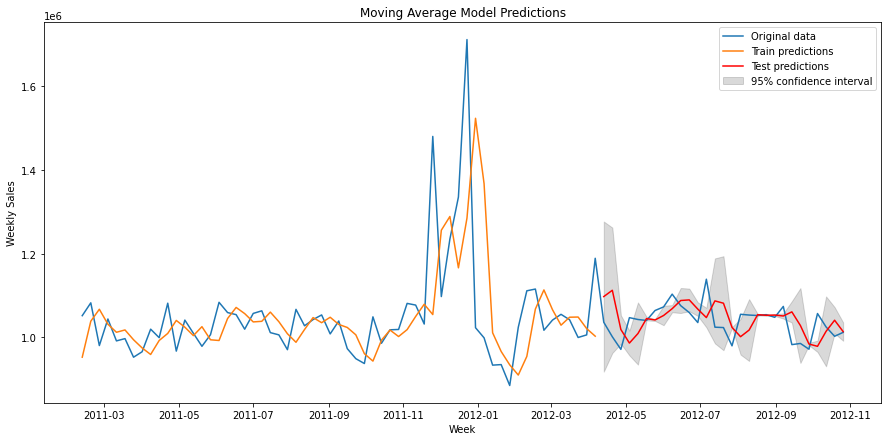

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(ma_df.index[53:], ma_df['t'][53:], label='Original data')
plt.plot(ma_train.index[53:], train_predictions, label='Train predictions')
plt.plot(ma_test.index, predictions, color='red', label='Test predictions')
plt.fill_between(ma_test.index, lower_series, upper_series, color='k', alpha=.15, label='95% confidence interval')
plt.title('Moving Average Model Predictions')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Weekly Sales')

This moving average model performs slightly worse than the baseline with a test MAPE of 0.0370. This suggests that seasonal differencing makes the data extremely stationary. 

## **Seasonal Moving Average Model**

The moving average model performs slightly worse than the baseline. A combination of both that may perform better is a seasonal moving average model, which uses values a year prior while smoothing out predictions over a 2-window average. 

In [ ]:
values = weekly_df[['Weekly_Sales']]
diff_ma_df = pd.concat([values.shift(52).rolling(2).mean(), values.shift(52).rolling(2).std(), values], axis=1)
diff_ma_df.columns = ['diff_rolling_mean', 'diff_rolling_std', 't']

diff_ma_train, diff_ma_test = train_test_split(diff_ma_df, train_size=0.8, shuffle=False)
X_train, y_train = diff_ma_train['diff_rolling_mean'], diff_ma_train['t']
X_test, y_test = diff_ma_test['diff_rolling_mean'], diff_ma_test['t']
test_rolling_std = diff_ma_test['diff_rolling_std']

In [ ]:
diff_ma_test[['diff_rolling_mean', 't']].head()

,diff_rolling_mean,t
Date,,
2012-04-13,1.009564e+06,1.036206e+06
2012-04-20,1.040556e+06,1.001612e+06
2012-04-27,1.024519e+06,9.714844e+05
2012-05-04,1.004355e+06,1.047204e+06
2012-05-11,1.025646e+06,1.042797e+06


In [ ]:
# Train MAPE
train_predictions = list()
for x in X_train[53:]:
    yhat = x
    train_predictions.append(yhat)
print(mean_absolute_percentage_error(y_train[53:], train_predictions))

0.04410820750947442


In [ ]:
# Test MAPE
predictions = list()
for x in X_test:
    yhat = x
    predictions.append(yhat)
print(mean_absolute_percentage_error(y_test, predictions))

0.02643981773077869


In [ ]:
# Prediction interval for moving average under normal dist of residuals
upper_series = predictions + 1.96 * test_rolling_std / np.sqrt(2)
lower_series = predictions - 1.96 * test_rolling_std / np.sqrt(2)

In [ ]:
errors = [mean_absolute_percentage_error(y_train[53:], train_predictions), mean_absolute_percentage_error(y_test, predictions)]
types = ['train', 'test']
pd.DataFrame(errors, index=types).rename(columns={0:'MAPE'})

,MAPE
train,0.044108
test,0.026440


Text(0, 0.5, 'Weekly Sales')

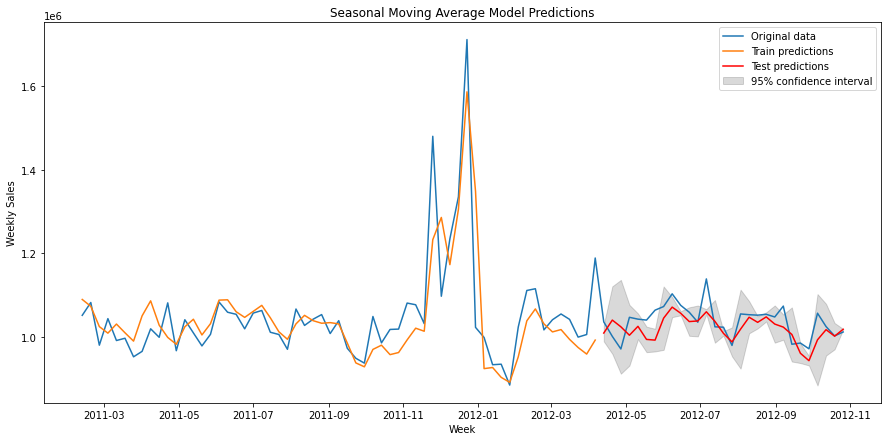

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(diff_ma_df.index[53:], diff_ma_df['t'][53:], label='Original data')
plt.plot(diff_ma_train.index[53:], train_predictions, label='Train predictions')
plt.plot(diff_ma_test.index, predictions, color='red', label='Test predictions')
plt.fill_between(diff_ma_test.index, lower_series, upper_series, color='k', alpha=.15, label='95% confidence interval')
plt.title('Seasonal Moving Average Model Predictions')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Weekly Sales')

The seasonal moving average is slightly better than the baseline model, with a test MAPE of 0.0264. However, it seems that the smoothing effect is relatively minor. 

## **Seasonal Exponentially Weighted Model**

The seasonal moving average model outperforms the baseline slightly. Instead of using a simple rolling average, a better model might use exponentially weighted averages to weigh more recent observations heavily. 

In [ ]:
values = weekly_df[['Weekly_Sales']]
ewma_df = pd.concat([values.shift(52).ewm(alpha=0.8).mean(), values.shift(52).ewm(alpha=0.8).std(), values], axis=1)
ewma_df.columns = ['rolling_ewm', 'rolling_ewm_std', 't']

ewma_train, ewma_test = train_test_split(ewma_df, train_size=0.8, shuffle=False)
X_train, y_train = ewma_train['rolling_ewm'], ewma_train['t']
X_test, y_test = ewma_test['rolling_ewm'], ewma_test['t']
test_rolling_std = ewma_test['rolling_ewm_std']

In [ ]:
ewma_test[['rolling_ewm', 't']].head()

,rolling_ewm,t
Date,,
2012-04-13,1.001280e+06,1.036206e+06
2012-04-20,1.065619e+06,1.001612e+06
2012-04-27,9.869911e+05,9.714844e+05
2012-05-04,1.030500e+06,1.047204e+06
2012-05-11,1.014031e+06,1.042797e+06


In [ ]:
# Train MAPE
train_predictions = list()
for x in X_train[53:]:
    yhat = x
    train_predictions.append(yhat)
print(mean_absolute_percentage_error(y_train[53:], train_predictions))

0.029934044920068223


In [ ]:
# Test MAPE
predictions = list()
for x in X_test:
    yhat = x
    predictions.append(yhat)
print(mean_absolute_percentage_error(y_test, predictions))

0.024379829095215112


In [ ]:
# Prediction interval for moving average under normal dist of residuals
upper_series = predictions + 1.96 * test_rolling_std / np.sqrt(2)
lower_series = predictions - 1.96 * test_rolling_std / np.sqrt(2)

In [ ]:
errors = [mean_absolute_percentage_error(y_train[53:], train_predictions), mean_absolute_percentage_error(y_test, predictions)]
types = ['train', 'test']
pd.DataFrame(errors, index=types).rename(columns={0:'MAPE'})

,MAPE
train,0.029934
test,0.024380


Text(0, 0.5, 'Weekly Sales')

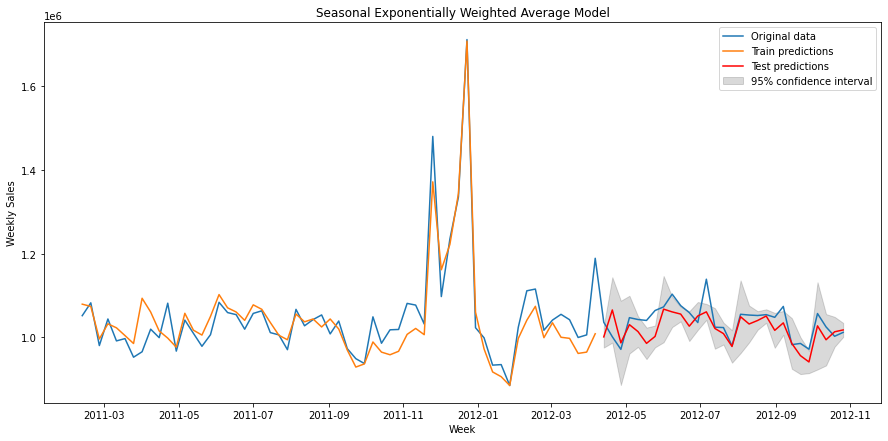

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(ewma_df.index[53:], ewma_df['t'][53:], label='Original data')
plt.plot(ewma_train.index[53:], train_predictions, label='Train predictions')
plt.plot(ewma_test.index, predictions, color='red', label='Test predictions')
plt.fill_between(ewma_test.index, lower_series, upper_series, color='k', alpha=.15, label='95% confidence interval')
plt.title('Seasonal Exponentially Weighted Average Model')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Weekly Sales')

The seasonal exponentially weighted average model notably outperforms the seasonal moving average model and the baseline model, with a test MAPE of 0.0243. This reinforces our hypothesis that weighing more recent observations heavily results in better predictions. 

## **SARIMA Model**

Another model that makes sense here is the ARIMA model for time series. However, it does not account for seasonal patterns. So instead we use SARIMA, which assumes current values are a linear combination of past values and errors in addition to seasonal patterns. We search for optimal parameters using auto_arima and set seasonality to True.

In [ ]:
copy_df = weekly_df['Weekly_Sales'].copy()
y_train, y_test = train_test_split(copy_df, train_size=0.8, shuffle=False)

In [ ]:
sarima_model = pm.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf', max_p=5, max_q=5, m=15, start_P=0, seasonal=True,
                         d=None, D=1, trace=True, error_action='ignore', suppress_warnings=True, 
                         stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[15] intercept   : AIC=2677.570, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[15] intercept   : AIC=2699.629, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[15] intercept   : AIC=2682.396, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[15] intercept   : AIC=2688.614, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[15]             : AIC=2698.666, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[15] intercept   : AIC=2691.319, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[15] intercept   : AIC=2679.164, Time=0.56 sec
 ARIMA(1,0,1)(0,1,2)[15] intercept   : AIC=2679.292, Time=1.31 sec
 ARIMA(1,0,1)(1,1,0)[15] intercept   : AIC=2680.570, Time=0.47 sec
 ARIMA(1,0,1)(1,1,2)[15] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(1,0,0)(0,1,1)[15] intercept   : AIC=2680.914, Time=0.37 sec
 ARIMA(2,0,1)(0,1,1)[15] intercept   : AIC=2679.132, Time=0.65 sec
 ARIMA(1,0,2)(0,1,1)[15] intercept   : AIC=2679.679, Time=0.83 sec
 ARIMA(0,0,0)(0,1,1)[15] intercept   : AIC=2697.932, Time=0.49 sec
 ARIMA(0,0,2)(0,1,1)[15]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  114
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 15)   Log Likelihood               -1323.956
Date:                              Mon, 12 Dec 2022   AIC                           2661.913
Time:                                      04:39:03   BIC                           2680.078
Sample:                                  02-05-2010   HQIC                          2669.263
                                       - 04-06-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5690      0.322      1.770      0.077      -0.061       1.199
ar.L2          0.7861      0.360      2.186      0.029       0.081       1.491
ar.L3         -0.3699      0.132     -2.799      0.005      -0.629      -0.111
ma.L1         -0.2087      0.358     -0.583      0.560      -0.911       0.493
ma.L2         -0.6549      0.332     -1.971      0.049      -1.306      -0.004
ma.S.L15      -0.7346      0.210     -3.496      0.000      -1.146      -0.323
sigma2      2.868e+10   1.81e-11   1.58e+21      0.000    2.87e+10    2.87e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                43.93
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.73
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.51e+37. Standard errors may be unstable.
"""

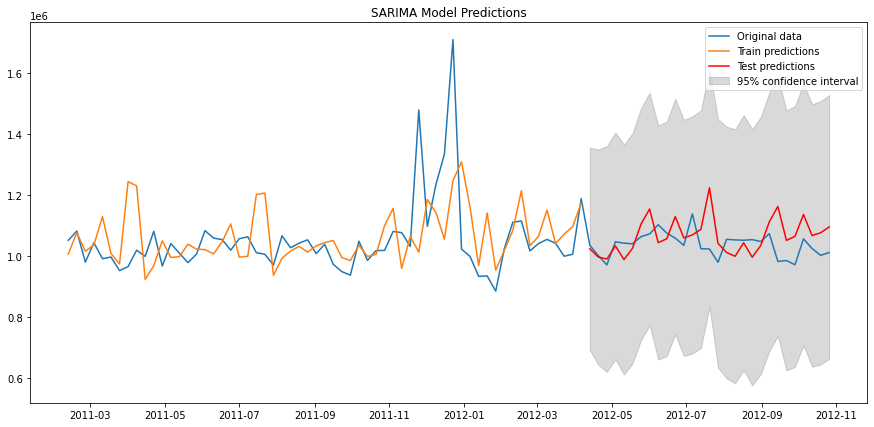

In [ ]:
n_periods = len(y_test)
fitted, confint = sarima_model.predict(n_periods=n_periods, return_conf_int=True)
fitted.index = y_test.index
lower_series = pd.Series(confint[:, 0], index=y_test.index)
upper_series = pd.Series(confint[:, 1], index=y_test.index)
train_predictions = sarima_model.predict_in_sample()

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(copy_df[53:], label='Original data')
plt.plot(train_predictions[53:], label='Train predictions')
plt.plot(fitted, color='red', label='Test predictions')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15, label='95% confidence interval')
plt.legend()
plt.title("SARIMA Model Predictions")
plt.show()

In [ ]:
# Train MAPE
print(mean_absolute_percentage_error(y_train[53:], train_predictions[53:]))

0.07736871307202772


In [ ]:
# Test MAPE
print(mean_absolute_percentage_error(y_test, fitted))

0.05507845857357268


In [ ]:
errors = [mean_absolute_percentage_error(y_train[53:], train_predictions[53:]), mean_absolute_percentage_error(y_test, fitted)]
types = ['train', 'test']
pd.DataFrame(errors, index=types).rename(columns={0:'MAPE'})

,MAPE
train,0.077369
test,0.055078


The SARIMA model produces decent predictions but does not outperform the baseline or the seasonal exponentially weighted average model, with a test MAPE of 0.0551. The reason for this is that there may simply not be enough data for the model to train on, and therefore patterns are less apparent - it is difficult for the model to capture all relevant seasonality trends and repeating patterns, and to make inferences on roughly two years of data. One reason that the baseline and the seasonal exponentially weighted average models work well is because of their simplicity in the context of limited data.

For future work, it would be worth collecting data over a longer period for fitting more complex models. Within this period from 2010 to 2012 simple models based on seasonality work extremely well, but it is likely they will underperform over a longer horizon as they would be worse at capturing all relevant patterns.

## **Multivariate Random Forest**


Next, we will test the performance of several kinds of Random Forest models. In theory, random forests could work well as they handle outliers well (significantly higher-performing stores are outliers of a sort) and non-linear data, like time series.

Next, here is the training and test split used for this section of modeling; rather than a random 80-20 split, in the case of time series we split the data between the first 80 percent of observations and final 20 percent with respect to time.

Text(0.5, 1.0, 'Weekly Sales - Training / Test Split')

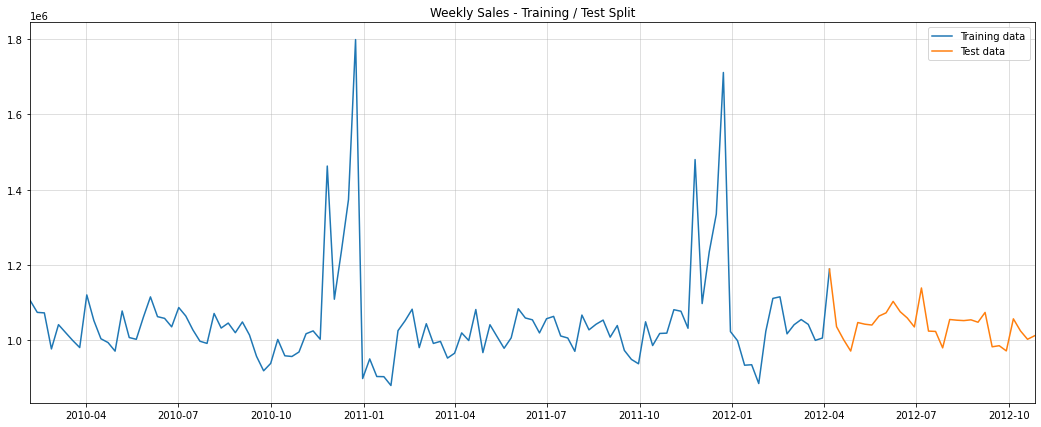

In [ ]:
df_train = weekly_df.iloc[:-29]
df_test = weekly_df.iloc[-30:]
df_train = df_train["Weekly_Sales"]
df_test = df_test["Weekly_Sales"]

plt.figure(figsize = (18,7))
plt.plot(df_train, label="Training data")
plt.plot(df_test, label = "Test data")
plt.legend()
plt.grid(alpha=0.5)
plt.margins(x=0)
plt.title("Weekly Sales - Training / Test Split")

Next, we'll fit a multivariate random forest model onto the data, with Weekly Sales as the response variable and all other features as predictors. Just to illustrate an example, we will initially use a depth of 5; each model from here out will run with 1000 trees, as that is what my local machine could easily handle.

In [ ]:
df_train = weekly_df.iloc[:-29]
df_test = weekly_df.iloc[-30:] 

X_train = df_train.iloc[:, df_train.columns != "Weekly_Sales"].values
y_train = df_train["Weekly_Sales"].values
X_test = df_test.iloc[:, df_test.columns != "Weekly_Sales"].values
y_test = df_test["Weekly_Sales"].values

scaler = StandardScaler().fit(np.concatenate([X_train, X_test], axis=0))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

tree_depth = 5
n_trees = 1000

rf = RandomForestRegressor(max_depth = tree_depth, max_features = "auto", n_estimators = n_trees)
rf.fit(X_train, y_train)

random_forest_train_score = mean_absolute_percentage_error(y_train, rf.predict(X_train))
random_forest_test_score = mean_absolute_percentage_error(y_test, rf.predict(X_test))

print(
    "The random forest of depth-{} and {} trees achieves the "
    "following MAPE scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-5 and 1000 trees achieves the following MAPE scores:

	train	0.0354
	TEST	0.0724


To improve the model, we can do some hyperparameter tuning with respect to tree depth.

In [ ]:
#Hyperparameter tuning for ideal tree depth
depths = list(range(1, 20))
mape_scores = []
for i in depths:
    rf = RandomForestRegressor(max_depth = tree_depth, max_features = "auto", n_estimators = n_trees)
    rf.fit(X_train, y_train)
    mape_scores.append(mean_absolute_percentage_error(y_test, rf.predict(X_test)))

Best tree depth is at 5 with a MAPE of 0.07


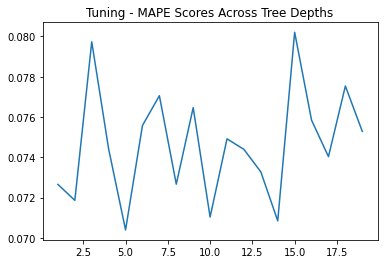

In [ ]:
plt.plot(depths, mape_scores)
plt.title("Tuning - MAPE Scores Across Tree Depths")
min_mape = np.min(mape_scores)
best_depth = mape_scores.index(min_mape) + 1
print("Best tree depth is at", best_depth, "with a MAPE of", round(min_mape, 3))

Here is a visualization of the best-depth model's predictions:

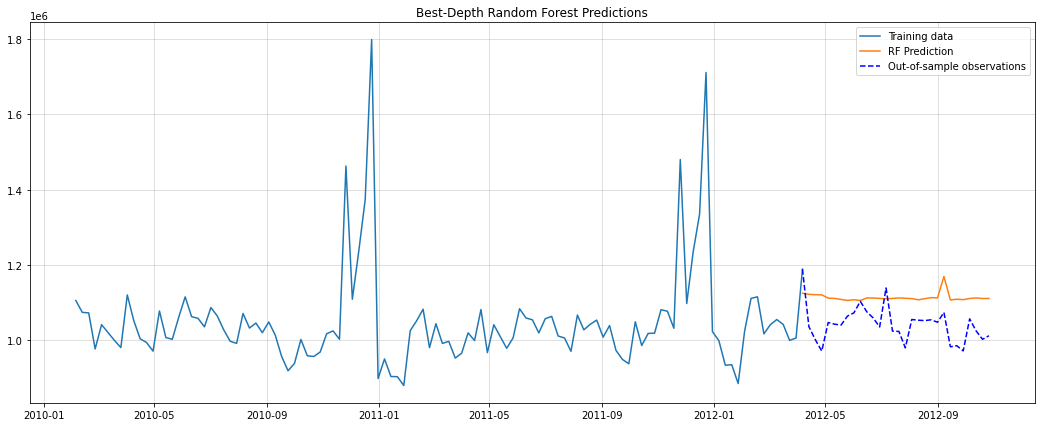

In [ ]:
ideal_rf = RandomForestRegressor(max_depth = best_depth, max_features = "auto", n_estimators = n_trees)
ideal_rf.fit(X_train, y_train)

predictions_forest = ideal_rf.predict(X_test)

plt.figure(figsize = (18,7))
plt.grid(alpha=0.5)
plt.plot(df_train["Weekly_Sales"], label="Training data")
plt.plot(df_test["Weekly_Sales"].index, predictions_forest, label = "RF Prediction")
plt.plot(df_test["Weekly_Sales"], color = "blue", label = "Out-of-sample observations", ls="dashed")
plt.title("Best-Depth Random Forest Predictions")
plt.legend();

Visually, the model does not seem to fit the data remarkably well, and it is far more stationary that the train or test datasets. This is likely due to the same conclusions suggested by the above findings, that is to say that exogenous features do not have a very significant impact on weekly sales. As a final note with this mode, it's worth investigating feature importance:

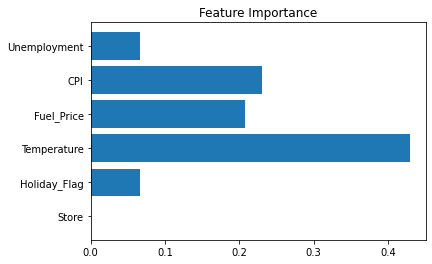

In [ ]:
col_names = df_train.iloc[:, df_train.columns != "Weekly_Sales"].columns
plt.barh(col_names, ideal_rf.feature_importances_)
plt.title("Feature Importance");

It makes sense that store number has no importance, since this is predicting on average sales across all stores. Interestingly, the most important feature is temperature, which may just be serving as a proxy for the seasonality present in the data.

## **Fixed Effects Model**

Next, we will be implementing a Fixed Effect (FE) Model. A fixed effects model is well suited for panel data, a 
dataset with time series for different units (in our case, stores). The primary goal of a FE model is to deal
with Omitted Variable Bias/ endogeniety. While analyzing the effects of Independent Variables 
(in our case, Holiday_flag, Temperature, Fuel_Price etc), there may exist ommitted variable not 
included in our deature set which bias the predictive effect of the features present in our dataset. Our FE model 
is geared to address this issue, and in the process hope to generate decent predictions for Weekly Sales. 

Compared to many other methods we have used to analyze Walmart Sales (primarily time series methods which mainly
utilize the value of our response at earlier time periods), using a FE model will allow us to more wholly 
incorporate information introduced by our features in the model. These are some motivations for using a FE model. As was evident in the EDA, since seasonality is strong in the data, we will also use the weekly sales from the previous few weeks as part of our feature set.

A FE model works as follows: the primary assumption underlying this model is that each unit (Store) has some 
unobserved individual effects that are fixed. By using data points at various time stamps, we are able to theoretically 
cancel out these store-specific effects to more clearly ascertain what the effect of our features is. Without getting
into too many details, one implicated of this assumption is that there exists a non-zero correlation between the 
features in our dataset and these unobserved variables. What this practically means is that store specific effects
(perhaps how geography and population density of that particular store effects Weekly Sales) are correlated to variables
like Unemployment and CPI. 

The general blueprint for our execution of this model is as follows. First, we will use the model to predict sales
for each store. Then, we will average the Sales across all stores so that our response variable does not change. 

In [ ]:
# loading and formatting the data to apply panel data methods 
df = pd.read_csv('Walmart_Store_sales.csv')
df['Date'] = pd.to_datetime(df['Date'], format = "%d-%m-%Y")

n1 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=1)))].index[0]
df['Lagged_1'] = df['Weekly_Sales'].shift(+n1)
n2 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=2)))].index[0]
df['Lagged_2'] = df['Weekly_Sales'].shift(+n2)
n3 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=3)))].index[0]
df['Lagged_3'] = df['Weekly_Sales'].shift(+n3)
n4 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=4)))].index[0]
df['Lagged_4'] = df['Weekly_Sales'].shift(+n4)
n5 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=5)))].index[0]
df['Lagged_5'] = df['Weekly_Sales'].shift(+n5)
n6 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=6)))].index[0]
df['Lagged_6'] = df['Weekly_Sales'].shift(+n6)
n7 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=7)))].index[0]
df['Lagged_7'] = df['Weekly_Sales'].shift(+n7)
n8 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=8)))].index[0]
df['Lagged_8'] = df['Weekly_Sales'].shift(+n8)
n9 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=9)))].index[0]
df['Lagged_9'] = df['Weekly_Sales'].shift(+n9)
n10 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=10)))].index[0]
df['Lagged_10'] = df['Weekly_Sales'].shift(+n10)
n11 = df[df['Date'].isin(pd.to_datetime(df['Date'] + pd.DateOffset(weeks=11)))].index[0]
df['Lagged_11'] = df['Weekly_Sales'].shift(+n11)

# dividing 80% of data for training and 20% for testing 
df_train = df[(df.Date < "2012-04-13")]
df_test = df[(df.Date >= "2012-04-13")]

df_train = df_train.set_index(['Store','Date'])
df_test = df_test.set_index(['Store','Date'])

# specifiying the exogenous and endogenous variables of our model, and scaling  
exog_vars = ["Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment",'Lagged_1','Lagged_2','Lagged_3','Lagged_4','Lagged_5','Lagged_6','Lagged_7','Lagged_8','Lagged_9','Lagged_10','Lagged_11']
endog_vars = ['Weekly_Sales']

exog_train = sm.add_constant(df_train[exog_vars])
exog_test = sm.add_constant(df_test[exog_vars])

# scaling our non-binary predictors 
non_binary_predictors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
exog_train[non_binary_predictors] = StandardScaler().fit_transform(exog_train[non_binary_predictors])
exog_test[non_binary_predictors] = StandardScaler().fit_transform(exog_test[non_binary_predictors])

In [ ]:
# training and fitting the fixed effects model
fe_model = PanelOLS(df_train[endog_vars], exog_train, entity_effects = True, check_rank=False)
fe_results = fe_model.fit()
print(fe_results)

# predictions 
pred_train = fe_results.predict(exog_train)
pred_test = fe_results.predict(exog_test)

                          PanelOLS Estimation Summary                           
Dep. Variable:           Weekly_Sales   R-squared:                        0.2623
Estimator:                   PanelOLS   R-squared (Between):              0.3792
No. Observations:                5119   R-squared (Within):               0.2623
Date:                Mon, Dec 12 2022   R-squared (Overall):              0.3673
Time:                        04:43:34   Log-likelihood                -6.829e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      112.43
Entities:                          45   P-value                           0.0000
Avg Obs:                       113.76   Distribution:                 F(16,5058)
Min Obs:                       103.00                                           
Max Obs:                       114.00   F-statistic (robust):             112.43
                            

In [ ]:
# taking the mean or sales for each week across all stores, for training and testing data 
df_train_mean = df_train.groupby('Date')['Weekly_Sales'].mean()
df_test_mean = df_test.groupby('Date')['Weekly_Sales'].mean()
pred_train_mean = pred_train.groupby('Date')['predictions'].mean()
pred_test_mean = pred_test.groupby('Date')['predictions'].mean()

# calculating a baseline standard deviation assuming normally distributed residuals to use in plotting
std = np.std(df_test_mean - pred_test_mean)*math.sqrt(1+(1/len(df_train_mean)))

Text(0, 0.5, 'Weekly Sales')

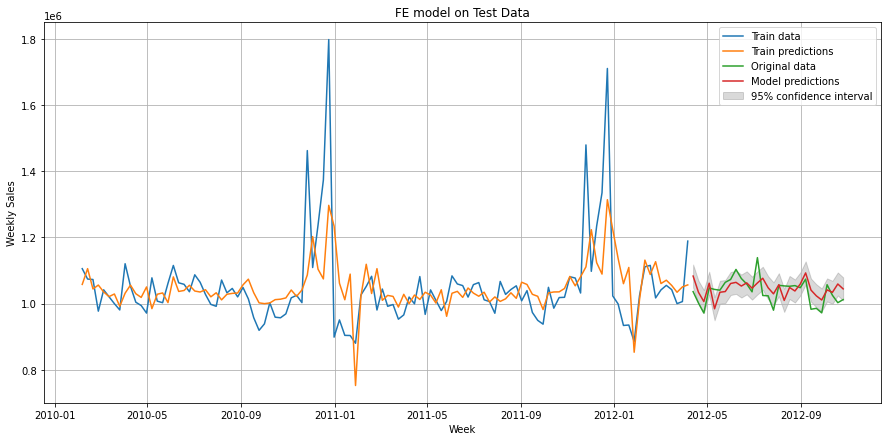

In [ ]:
# plotting results 
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_train_mean, label='Train data')
plt.plot(pred_train_mean, label='Train predictions')
plt.plot(df_test_mean, label='Original data')
plt.plot(pred_test_mean, label='Model predictions')
plt.fill_between(pred_test_mean.index,pred_test_mean-std, pred_test_mean+std, color='k', alpha=.15, label='95% confidence interval')
plt.title('FE model on Test Data')
plt.legend()
plt.grid()
plt.xlabel('Week')
plt.ylabel('Weekly Sales')

In [ ]:
mean_absolute_percentage_error(df_test_mean,pred_test_mean)

0.028608323761911872

It seems that using this approach helps us clearly ascertain what the precise effect of our features on Weekly 
Sales is. The P-values for each feature as well as for the overall poolability of the data support this conclusion. Additionally, this model also performs adequately well in prediction, yielding a MAPE of 2.8%.

One possible avenue of slight improvement is to use a Random Effects model, a related panel data method which 
assumes some randomness in these unobserved variables over time. This model determines individual effects of 
unobserved, independent variables as random variables over time. 

In [ ]:
# training the random effects model 
re_model = RandomEffects(df_train[endog_vars], exog_train)
re_results = re_model.fit()
print(re_results)

# predictions 
pred_train = re_results.predict(exog_train)
pred_test = re_results.predict(exog_test)

pred_train_mean = pred_train.groupby('Date')['predictions'].mean()
pred_test_mean = pred_test.groupby('Date')['predictions'].mean()
std = np.std(df_test_mean - pred_test_mean)*math.sqrt(1+(1/len(df_train_mean)))

                        RandomEffects Estimation Summary                        
Dep. Variable:           Weekly_Sales   R-squared:                        0.9055
Estimator:              RandomEffects   R-squared (Between):              0.9980
No. Observations:                5119   R-squared (Within):               0.0111
Date:                Mon, Dec 12 2022   R-squared (Overall):              0.9055
Time:                        04:43:34   Log-likelihood                -6.909e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3054.1
Entities:                          45   P-value                           0.0000
Avg Obs:                       113.76   Distribution:                 F(16,5102)
Min Obs:                       103.00                                           
Max Obs:                       114.00   F-statistic (robust):             3054.1
                            

Text(0, 0.5, 'Weekly Sales')

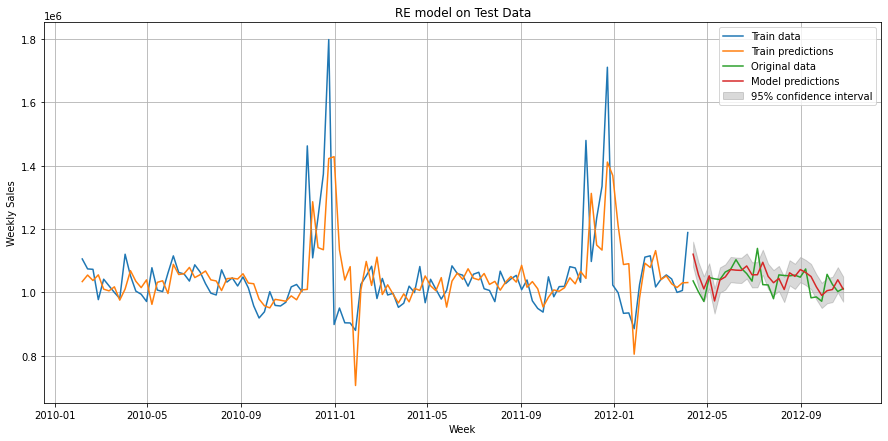

In [ ]:
# plotting results 
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_train_mean, label='Train data')
plt.plot(pred_train_mean, label='Train predictions')
plt.plot(df_test_mean, label='Original data')
plt.plot(pred_test_mean, label='Model predictions')
plt.fill_between(pred_test_mean.index,pred_test_mean-std, pred_test_mean+std, color='k', alpha=.15, label='95% confidence interval')
plt.title('RE model on Test Data')
plt.legend()
plt.grid()
plt.xlabel('Week')
plt.ylabel('Weekly Sales')

In [ ]:
mean_absolute_percentage_error(df_test_mean,pred_test_mean)

0.030489623992448884

While this model, similar to FE, is good at defining the effect of each of our features, it's not better at predicting on the test data on a MAPE basis. 

## **Gradient Boosting Model**

Gradient Boosting is a boosting technique that uses a gradient descent approach to decrease mistakes. Gradient descent is a straightforward iterative optimization approach for reducing a loss function. Gradient boosting, in contrast to standard boosting, adjusts weights based on a gradient, which is determined by the direction in which the loss decreases the fastest in the loss function. Random forests may not be as accurate as gradient enhancing trees as boosting can detect intricate patterns in the data because we train them to correct their mistakes. However, the boosted trees may overfit and begin modeling the noise if the data are noisy.

We will use XGBoost to model Walmart's sales as it is a continuous time series data. XGBoost is a robust and and well-liked tool for creating gradient boosting models in Python. 

Strengths: Its ability to automatically manage missing values and mixed data types, which are frequent in time series data, is one of XGBoost's primary advantages when used to analyze time series sales data. Furthermore, XGBoost is quick and effective, which is crucial when working with big datasets. Even though we don't have missing values in our dataset, it contains many observations, making XGBoost capable of handling it.

Weaknesses: A big limitation of XGBoost is that it is not natively designed for time series data, so we have to perform additional preprocessing steps to make the data suitable for use. Furthermore, XGBoost is a boosting method that, if not utilized appropriately, can overfit the data and be challenging to modify. The confidence intervals are also around the test predictions as we don't have many data points to choose from, making it a drawback of the XGBoost model.

## **XGBoost Model 1**

The XGBRegressor class from the XGBoost library can be used to train a GBM.

Feature importance: XGBoost offers a feature importance score for each input column, just like decision trees and random forests do.

First, we will try predicting the data using a simple XGBoost model. As our data is continuous, we will use the XGBRegressor model on our train data. We will also plot the figure importance plot to visualize what is the most important predictor.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model1 = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42, n_jobs=-1, subsample=0.9)
model1.fit(X_train, y_train)
preds = model1.predict(X_train)
preds1 = model1.predict(X_test)

The feature importance graph does not seem persuasive enough as it would be unlikely for temperature to be the most important predictor in the model. However, let's continue to visualize how the data predicted on the test data compares with the model.

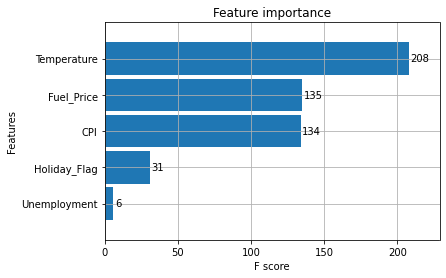

In [ ]:
f_imp = plot_importance(model1, height=0.9)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

scores = cross_val_score(model1, X_train, y_train,cv=10, scoring='neg_mean_squared_error')
avg_score = -np.mean(scores)
avg_score

23233807829.12368

In [ ]:
train_pred = model1.predict(X_train)
test_pred = model1.predict(X_test)

test_pred_df = pd.DataFrame(test_pred,index = y_test.index, columns = ['test_pred'])
train_pred_df = pd.DataFrame(train_pred,index = y_train.index, columns = ['train_pred'])

mse_train = mean_squared_error(y_train, train_pred_df)
print("MSE Train: %.2f" % mse_train)
mse_test = mean_squared_error(y_test, test_pred_df)
print("MSE Test: %.2f" % mse_test)

MSE Train: 905686320.22
MSE Test: 10522541828.76


In [ ]:
from scipy import stats

def calculate_confidence_interval(X_train, y_train, X_test, iters=100):
    all_preds = []

    for i in range(iters):
        model1 = xgb.XGBRegressor(objective ='reg:squarederror', random_state=5*i, n_jobs=-1, subsample=0.9)
        model1.fit(X_train, y_train)
        preds1 = model1.predict(X_test)
        all_preds.append(preds1)


    all_preds = np.array(all_preds)

    # Calculate the mean and standard deviation of the predictions
    mean = np.mean(all_preds, axis=0)
    stdev = np.std(all_preds, axis=0)
    n = len(all_preds[0])

    # Calculate the 95% confidence interval
    conf_int_95 = stats.t.interval(0.95, n - 1, mean, stdev / np.sqrt(n))

    return conf_int_95


In [ ]:
conf_ints = calculate_confidence_interval(X_train, y_train, X_test, iters=1000)


lower_conf_df = pd.DataFrame(conf_ints[0],index = y_test.index, columns = ['lower conf int'])
upper_conf_df = pd.DataFrame(conf_ints[1],index = y_test.index, columns = ['upper conf int'])

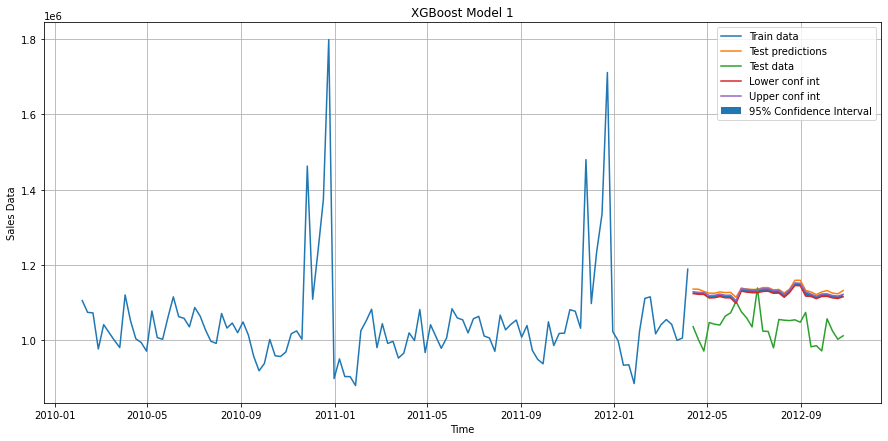

In [ ]:
n_periods = len(X_test)
test_pred = model1.predict(X_test)
index_list = list(y_test.index.values)

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(y_train, label='Train data')
plt.plot(test_pred_df, label='Test predictions')
plt.plot(y_test, label='Test data')
plt.fill_between(x = index_list, y1 = lower_conf_df['lower conf int'], y2 = upper_conf_df['upper conf int'], label = '95% Confidence Interval')
plt.plot(lower_conf_df, label='Lower conf int')
plt.plot(upper_conf_df, label='Upper conf int')
plt.grid()
plt.legend()
plt.title("XGBoost Model 1")
plt.xlabel("Time")
plt.ylabel("Sales Data")
plt.show()

In [ ]:
mape_xgb_1 = mean_absolute_percentage_error(y_test, preds1)
print("MAPE = " + str(mape_xgb_1))

MAPE = 0.09319153491050511


The Mean Absolute Percentage Error for this model is ~11%, which is not that great. This can also be observed by the predicted test data in the graph above. Let's try to tune the hyperparameters next. This will help us to adjust the capacity of model and reduce overfitting.

## **XGBoost Model 2**

Similar to XGBoost Model 1, we will use the XGBRegressor model on our train data. Additionally, we will also plot the figure importance plot to visualize what is the most important predictor. An interesting approach to find the best hyperparameter is through the optimization algorithm, which Scikit-learn provides. 

Here, we use GridSearchCV() from Scikit-learn to tune our XGBoost model. Grid Search is one of the two most popular optimizers. It is a thorough search over all possible arrangements of the provided parameter values. For example, Grid Search will run over 6 possible possibilities if you specify 2 possible values for max depth and 3 for n estimators.

Based on Model 1 and our best estimates, this is a list of the possible range of hyperparameters that we will try to tune.

In [ ]:
max_depth = list(range(7,10))
colsample_bytree = [0.4, 0.6, 0.8]
learning_rate = list(np.linspace(0.01,0.1,3))
n_estimators = list(range(500,1000,250))

Now, we will use GridSearchCV() for tuning, as explained above. This will help us find the best parameter values, that we can then regress using XGBRegressor.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': max_depth,
           'learning_rate': learning_rate,
           'n_estimators': n_estimators,
           'colsample_bytree': colsample_bytree}
xgbr = xgb.XGBRegressor(objective ='reg:squarederror', seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05500000000000001, 'max_depth': 7, 'n_estimators': 500}
Lowest RMSE:  143227.38484016113


Taking the best parameter values, we will now fit it in a new model (model2), and observe the predicted data as well as the important features.

In [ ]:
model2 = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42, n_jobs=-1, **clf.best_params_)
model2.fit(X_train, y_train)
preds = model2.predict(X_train)
preds1 = model2.predict(X_test)

Even now, it appears that temperature is the most significant factor, albeit fuel prices have caught up. Fuel price volatility affects the entire economy, not just consumers who have less money to spend. Anything that is moved by truck, train, or ship is impacted by the rising cost of fuel, especially diesel.

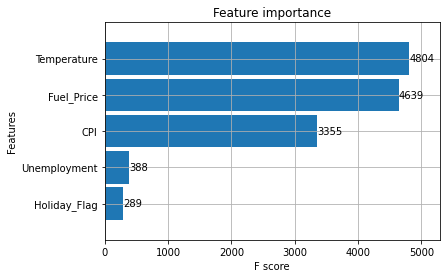

In [ ]:
f_imp = plot_importance(model2, height=0.9)

In [ ]:
scores = cross_val_score(model2, X_train, y_train,cv=10, scoring='neg_mean_squared_error')
xgb_2_score = -np.mean(scores)

In [ ]:
train_pred = model2.predict(X_train)
test_pred = model2.predict(X_test)

test_pred_df = pd.DataFrame(test_pred,index = y_test.index, columns = ['test_pred'])
train_pred_df = pd.DataFrame(train_pred,index = y_train.index, columns = ['train_pred'])

mse_train = mean_squared_error(y_train, train_pred_df)
print("MSE Train: %.2f" % mse_train)
mse_test = mean_squared_error(y_test, test_pred_df)
print("MSE Test: %.2f" % mse_test)

MSE Train: 15115.15
MSE Test: 6673749801.82


In [ ]:
from scipy import stats

def calculate_confidence_interval(X_train, y_train, X_test, iters=100):
    all_preds = []

    for i in range(iters):
        model2 = xgb.XGBRegressor(objective ='reg:squarederror', random_state=5*i, n_jobs=-1, subsample=0.8, colsample_bytree = 0.6, learning_rate = 0.05500000000000001, max_depth = 7, n_estimators = 500)
        model2.fit(X_train, y_train)
        preds1 = model2.predict(X_test)
        all_preds.append(preds1)


    all_preds = np.array(all_preds)

    # Calculate the mean and standard deviation of the predictions
    mean = np.mean(all_preds, axis=0)
    stdev = np.std(all_preds, axis=0)
    n = len(all_preds[0])

    # Calculate the 95% confidence interval
    conf_int_95 = stats.t.interval(0.95, n - 1, mean, stdev / np.sqrt(n))

    return conf_int_95

In [ ]:
conf_ints = calculate_confidence_interval(X_train, y_train, X_test, iters=1000)
lower_conf_df = pd.DataFrame(conf_ints[0],index = y_test.index, columns = ['lower conf int'])
upper_conf_df = pd.DataFrame(conf_ints[1],index = y_test.index, columns = ['upper conf int'])

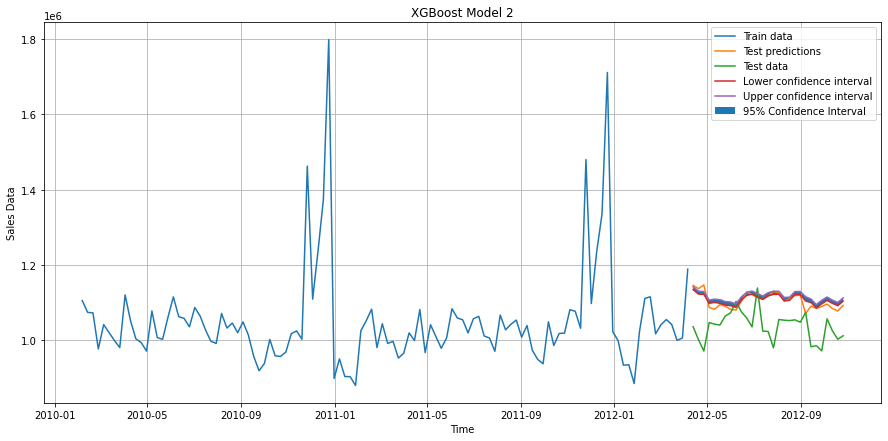

In [ ]:
n_periods = len(X_test)
test_pred = model2.predict(X_test)


fig, ax = plt.subplots(figsize=(15,7))
plt.plot(y_train, label='Train data')
plt.grid()
plt.plot(test_pred_df, label='Test predictions')
plt.plot(y_test, label='Test data')
plt.fill_between(x = index_list, y1 = lower_conf_df['lower conf int'], y2 = upper_conf_df['upper conf int'], label = "95% Confidence Interval")
plt.plot(lower_conf_df, label='Lower confidence interval')
plt.plot(upper_conf_df, label='Upper confidence interval')
plt.legend()
plt.title("XGBoost Model 2")
plt.xlabel("Time")
plt.ylabel("Sales Data")
plt.show()

In [ ]:
mape_xgb_2 = mean_absolute_percentage_error(y_test, preds1)
print("MAPE = " + str(mape_xgb_2))

MAPE = 0.06937198322581578


The Mean Absolute Percentage Error for Model 2 is ~6.9%, which is almost 100% better than Model 1. This makes sense as we have tuned our hyperparameters to reflect the best possible values that manages bias as well as variance successfully. 

However, the error is still pretty high compared to the other models. This can be explained by the fact that the data is very noisy and has been collected for a short period of time. While XGBoost may work out as a great model when working independently, it may not be best suited to handle this particular time-series data. Secondly, the XGBoost model may not have been properly tuned, which can result in subpar performance. In addition, if the XGBoost model is overfitting the data, it might perform worse on hypothetical data than a baseline model that is more generalizable.

Lastly, when comparing XGBoost to models that are specifically designed to model time series data, such as autocorrelation and fixed effects models, it may be difficult for the XGBoost model to outperform them as it is not natively built to handle time-series data.

Future Work: 

- Making use of regularization strategies to prevent the model from overfitting the training set of data.
- If at all possible, increase the amount of data in the training set to offer the model additional information to work with.
- Trying out various feature combinations to determine whether utilizing a different set of features can enhance the performance of the model.
- Combining several XGBoost models to increase performance.

## **Autoregressive Random Forests**


Next, we will try to fit an Autoregresive Random Forest, or a model that relies only on past response variables to predict future ones. Here is the class for performing this analysis: 

In [ ]:
class RandomForestARModel():
    """
    Autoregressive forecasting with Random Forests - from Sarem Seitz, https://www.sarem-seitz.com/forecasting-with-decision-trees-and-random-forests/
    """
    
    def __init__(self, n_lags=1, max_depth = 3, n_estimators=1000, random_state = 123,
                 log_transform = False, first_differences = False, seasonal_differences = None):
        """
        Args:
            n_lags: Number of lagged features to consider in autoregressive model
            max_depth: Max depth for the forest's regression trees
            random_state: Random state to pass to random forest
            
            log_transform: Whether the input should be log-transformed
            first_differences: Whether the input should be singly differenced
            seasonal_differences: Seasonality to consider, if 'None' then no seasonality is presumed
        """
        
        self.n_lags = n_lags
        self.model = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, random_state = random_state)
        
        self.log_transform = log_transform
        self.first_differences = first_differences
        self.seasonal_differences = seasonal_differences
        
        
        
    def fit(self, y):
        """
        Args:
            y: training data (numpy array or pandas series/dataframe)
        """
        #enable pandas functions via dataframes
        y_df = pd.DataFrame(y)
        self.y_df = deepcopy(y_df)
        
        #apply transformations and store results for retransformations
        if self.log_transform:
            y_df = np.log(y_df)
            self.y_logged = deepcopy(y_df)
        
        if self.first_differences:
            y_df = y_df.diff().dropna()
            self.y_diffed = deepcopy(y_df)
        
        if self.seasonal_differences is not None:
            y_df = y_df.diff(self.seasonal_differences).dropna()
            self.y_diffed_seasonal = deepcopy(y_df)
        
        
        #get lagged features
        Xtrain = pd.concat([y_df.shift(t) for t in range(1,self.n_lags+1)],axis=1).dropna()
        self.Xtrain = Xtrain
        
        ytrain = y_df.loc[Xtrain.index,:]
        self.ytrain = ytrain

        self.model.fit(Xtrain.values,ytrain.values.reshape(-1))

    
    
    def sample_forecast(self, n_periods = 1, n_samples = 10000, random_seed =123):
        """
        Draw forecasting samples by randomly drawing from all trees in the forest per forecast period
        Args:
            n_periods: Ammount of periods to forecast
            n_samples: Number of samples to draw
            random_seed: Random seed for numpy
        """
        samples = self._perform_forecast(n_periods, n_samples, random_seed)
        output = self._retransform_forecast(samples, n_periods)
        
        return output
    
    
    
    def _perform_forecast(self, n_periods, n_samples, random_seed):
        """
        Forecast transformed observations
        Args:
            n_periods: Ammount of periods to forecast
            n_samples: Number of samples to draw
            random_seed: Random seed for numpy
        """
        samples = []
        
        np.random.seed(random_seed)
        for i in range(n_samples):
            #store lagged features for each period
            Xf = np.concatenate([self.Xtrain.iloc[-1,1:].values.reshape(1,-1),
                                 self.ytrain.iloc[-1].values.reshape(1,1)],1)

            forecasts = []

            for t in range(n_periods):
                tree = self.model.estimators_[np.random.randint(len(self.model.estimators_))]
                pred = tree.predict(Xf)[0]
                forecasts.append(pred)
                
                #update lagged features for next period
                Xf = np.concatenate([Xf[:,1:],np.array([[pred]])],1)
            
            samples.append(forecasts)
        
        return samples
    
    
    
    def _retransform_forecast(self, samples, n_periods):
        """
        Retransform forecast (re-difference and exponentiate)
        Args:
            samples: Forecast samples for retransformation
            n_periods: Ammount of periods to forecast
        """
        
        full_sample_tree = []

        for samp in samples:
            draw = np.array(samp)
            
            #retransform seasonal differencing
            if self.seasonal_differences is not None:
                result = list(self.y_diffed.iloc[-self.seasonal_differences:].values)
                for t in range(n_periods):
                    result.append(result[t]+draw[t])
                result = result[self.seasonal_differences:]
            else:
                result = []
                for t in range(n_periods):
                    result.append(draw[t])
            
            #retransform first differences
            y_for_add = self.y_logged.values[-1] if self.log_transform else self.y_df.values[-1]
            
            if self.first_differences:
                result = y_for_add + np.cumsum(result)
            
            #retransform log transformation
            if self.log_transform:
                result = np.exp(result)
            
            full_sample_tree.append(result.reshape(-1,1))

        return np.concatenate(full_sample_tree,1)

Let's try fitting an ARF model, again arbitrarily with a tree depth of 5.

In [ ]:
df_train = weekly_df.iloc[:-29]
df_test = weekly_df.iloc[-30:]
df_train = df_train["Weekly_Sales"]
df_test = df_test["Weekly_Sales"]

model = RandomForestARModel(max_depth = 5, n_lags = 2, log_transform = True, first_differences = True, seasonal_differences = 12)
model.fit(df_train)
predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=100)
means_forest = np.mean(predictions_forest,1)
lowers_forest = np.quantile(predictions_forest,0.05,1)
uppers_forest = np.quantile(predictions_forest,0.95,1)

In [ ]:
print("The ARF model with depth 5 gives a MAPE of", round(mean_absolute_percentage_error(df_test, means_forest), 3))

The ARF model with depth 5 gives a MAPE of 0.164


At first glance, the performance of this model is in fact worse than the multivariate version. But just to be sure, let's do another round of hyperparameter tuning. 

In [ ]:
depths = list(range(1, 20))
mape_scores = []
for i in depths:
    model = RandomForestARModel(max_depth = i, n_lags = 2, log_transform = True, first_differences = True, seasonal_differences = 12)
    model.fit(df_train)
    predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=100)
    means_forest = np.mean(predictions_forest,1)
    mape_scores.append(mean_absolute_percentage_error(df_test, means_forest))

Best tree depth is at 1 with a MAPE of 0.111


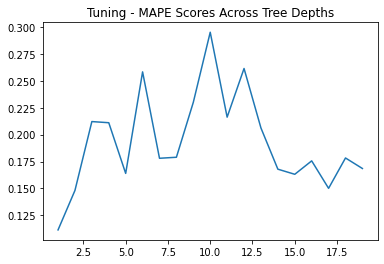

In [ ]:
plt.plot(depths, mape_scores)
plt.title("Tuning - MAPE Scores Across Tree Depths")
min_mape = np.min(mape_scores)
best_depth = mape_scores.index(min_mape) + 1
print("Best tree depth is at", best_depth, "with a MAPE of", round(min_mape, 3))

The best tree depth by far is at 1, which makes sense as the very nature of this autoregressive model is that it is only fitting on one feature of the data (i.e past sales).

Let's see the best-case ARF model:

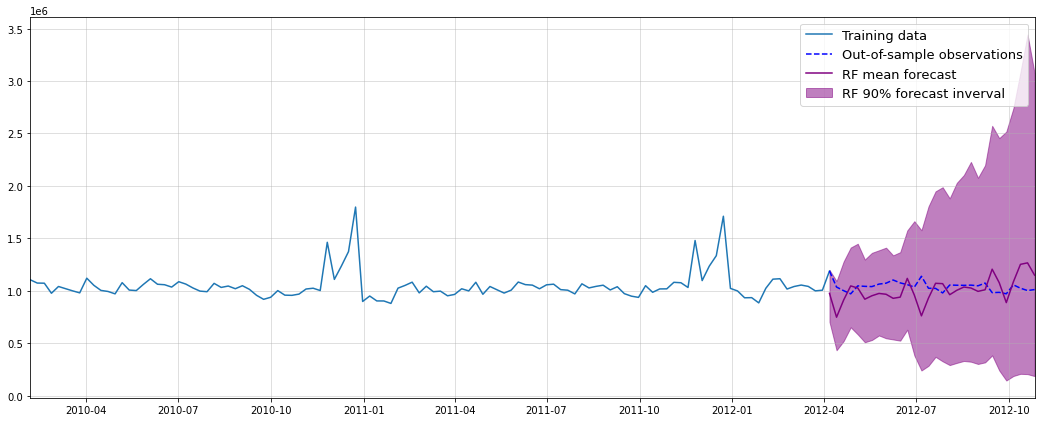

In [ ]:
model = RandomForestARModel(max_depth = best_depth, n_lags = 2, log_transform = True, first_differences = True, seasonal_differences = 12)
model.fit(df_train)
predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=100)
means_forest = np.mean(predictions_forest,1)
lowers_forest = np.quantile(predictions_forest,0.05,1)
uppers_forest = np.quantile(predictions_forest,0.95,1)

plt.figure(figsize = (18,7))
plt.grid(alpha=0.5)
plt.plot(df_train, label="Training data")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")
plt.plot(df_test.index,means_forest,color="purple", label = "RF mean forecast")
plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label = "RF 90% forecast inverval")
plt.legend(fontsize=13)
plt.margins(x=0)

This model's predictions are more variable than the original random forests, yet on the whole lead to a much higher MAPE.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn import preprocessing
from pandas.tseries.frequencies import to_offset
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import StandardScaler

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [ ]:
df = pd.read_csv("/content/Walmart_Store_sales.csv")

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


We find the aggregates of the weekly sales of all stores and other data to better understand Walmart's overall weekly sales.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
weekly_df = df.resample('W').mean() 
weekly_df.index = weekly_df.index + to_offset('-2D')
weekly_df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,23.0,1.105572e+06,0.0,34.037333,2.717844,167.730885,8.619311
2010-02-12,23.0,1.074148e+06,1.0,34.151333,2.694022,167.825608,8.619311
2010-02-19,23.0,1.072822e+06,0.0,37.719778,2.672067,167.871686,8.619311
2010-02-26,23.0,9.770794e+05,0.0,39.243556,2.683933,167.909657,8.619311
2010-03-05,23.0,1.041588e+06,0.0,42.917333,2.731200,167.947628,8.619311


In [ ]:
df_train, df_test = train_test_split(weekly_df, train_size=0.8, shuffle=False)
X_train, y_train = df_train, df_train[['Weekly_Sales']]
X_test, y_test = df_test, df_test[['Weekly_Sales']]


print(
    f"Our data contains {len(df_train):,} training samples "
    f"and {len(df_test):,} test samples.\n"
)

print("Training Data Information:\n")
df_train.info()

print("\nTraining Data Head:")
display(df_train.head())

print("\nTraining Data Summary Statistics:")
display(df_train.describe())

Our data contains 114 training samples and 29 test samples.

Training Data Information:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2010-02-05 to 2012-04-06
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         114 non-null    float64
 1   Weekly_Sales  114 non-null    float64
 2   Holiday_Flag  114 non-null    float64
 3   Temperature   114 non-null    float64
 4   Fuel_Price    114 non-null    float64
 5   CPI           114 non-null    float64
 6   Unemployment  114 non-null    float64
dtypes: float64(7)
memory usage: 7.1 KB

Training Data Head:


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,23.0,1.105572e+06,0.0,34.037333,2.717844,167.730885,8.619311
2010-02-12,23.0,1.074148e+06,1.0,34.151333,2.694022,167.825608,8.619311
2010-02-19,23.0,1.072822e+06,0.0,37.719778,2.672067,167.871686,8.619311
2010-02-26,23.0,9.770794e+05,0.0,39.243556,2.683933,167.909657,8.619311
2010-03-05,23.0,1.041588e+06,0.0,42.917333,2.731200,167.947628,8.619311



Training Data Summary Statistics:


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,114.0,1.140000e+02,114.000000,114.000000,114.000000,114.000000,114.000000
mean,23.0,1.049329e+06,0.078947,57.921571,3.258001,170.490563,8.183719
std,0.0,1.341105e+05,0.270847,15.410210,0.418555,2.481129,0.344524
min,23.0,8.799967e+05,0.000000,30.480889,2.672067,167.546485,7.419533
25%,23.0,9.923641e+05,0.000000,44.884333,2.837461,168.228794,8.097489
50%,23.0,1.023645e+06,0.000000,57.334333,3.281522,170.156382,8.291200
75%,23.0,1.063357e+06,0.000000,73.227722,3.636500,172.334765,8.475289
max,23.0,1.798476e+06,1.000000,82.176444,3.990756,175.409646,8.619311


In [ ]:
print("\Testing Data Head:")
display(df_test.head())

print("\Testing Data Statistics:")
display(df_test.describe())

\Testing Data Head:


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2012-04-13,23.0,1.036206e+06,0.0,58.300667,3.997778,175.492067,7.419533
2012-04-20,23.0,1.001612e+06,0.0,61.355556,3.984289,175.525642,7.419533
2012-04-27,23.0,9.714844e+05,0.0,62.776222,3.950911,175.559217,7.419533
2012-05-04,23.0,1.047204e+06,0.0,64.676000,3.906756,175.592791,7.419533
2012-05-11,23.0,1.042797e+06,0.0,64.838000,3.869689,175.626366,7.419533


\Testing Data Statistics:


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,29.0,2.900000e+01,29.000000,29.000000,29.000000,29.000000,29.000000
mean,23.0,1.037673e+06,0.034483,71.443510,3.754092,175.854696,7.273606
std,0.0,3.914209e+04,0.185695,7.626517,0.157742,0.373244,0.156065
min,23.0,9.714844e+05,0.000000,58.300667,3.460844,175.492067,6.953711
25%,23.0,1.012091e+06,0.000000,64.838000,3.632911,175.608191,7.237333
50%,23.0,1.042797e+06,0.000000,71.991333,3.788378,175.673522,7.237333
75%,23.0,1.057036e+06,0.000000,78.776444,3.869689,176.014468,7.419533
max,23.0,1.138956e+06,1.000000,81.580222,3.997778,176.652613,7.419533


First, we will be dropping the Weekly_Sales data from X_train as well as X_test as we want to observe the predicted data based on all other features besides the sales data.

In [ ]:
X_train = df_train.drop(['Weekly_Sales', 'Store'], axis=1)
X_test = df_test.drop(['Weekly_Sales', 'Store'], axis=1)


Here, we scale the non-binary predictors with very different ranges, which results in a mean of 0 for the predictors. Thus, when the predictor values are set to their means, it is simpler to understand the intercept component as the predicted value of Y.

In [ ]:
# Scale non-binary predictors with very different ranges 
scaler = StandardScaler()
non_binary_predictors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
X_train_scaled = scaler.fit_transform(X_train[non_binary_predictors])
X_test_scaled = scaler.transform(X_test[non_binary_predictors])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train[non_binary_predictors].columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test[non_binary_predictors].columns)

X_train = X_train.reset_index()
X_test = X_test.reset_index()

X_train = X_train_scaled.join(X_train.drop(non_binary_predictors, axis=1), how='outer').set_index('Date')
X_test = X_test_scaled.join(X_test.drop(non_binary_predictors, axis=1), how='outer').set_index('Date')


## **Autoregressive Random Forests, By-Store Approach**

The one variable that the Random Forest approaches thus far have not been able to test for is store number.

In theory, it may be possible to obtain an ensemble model by fitting a random forest model to each individual store, and then averaging those predictions.

Here is the data for Store #1; it's slightly different but follows the same seasonal pattern as the general data.

Text(0.5, 1.0, 'Weekly Sales - Store 1')

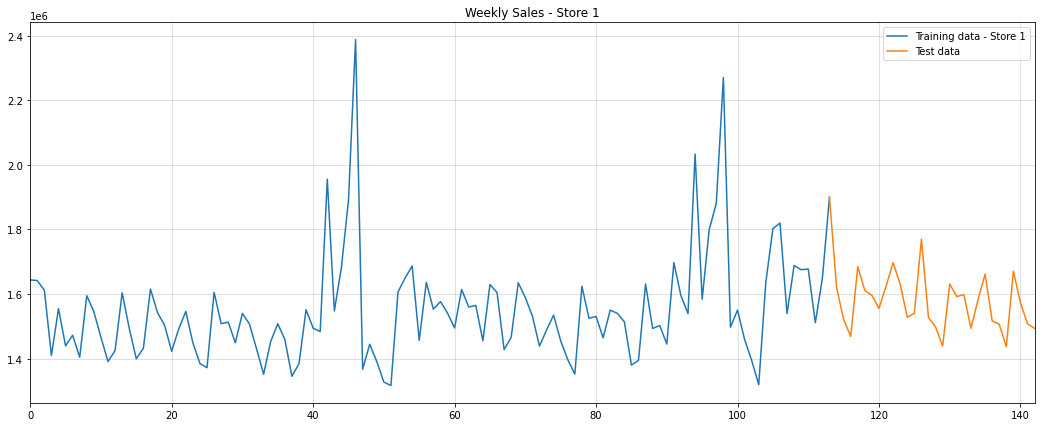

In [ ]:
df_bystore = df[["Store", "Weekly_Sales"]]

df_store1 = df_bystore[df_bystore["Store"] == 1]
df_store1
df_train_s1 = df_store1.iloc[:-29]
df_test_s1 = df_store1.iloc[-30:]
df_train_s1 = df_train_s1["Weekly_Sales"]
df_test_s1 = df_test_s1["Weekly_Sales"]

plt.figure(figsize = (18,7))
plt.plot(df_train_s1, label="Training data - Store 1")
plt.plot(df_test_s1, label = "Test data")
plt.legend()
plt.grid(alpha=0.5)
plt.margins(x=0)
plt.title("Weekly Sales - Store 1")

Next, we will fit a model to each store, keeping track of their respective predictions and MAPEs.

In [ ]:
by_store_preds = {"store":[],"preds":[]};
by_store_errors = {"store":[],"MAPE":[]};
for i in range(1,46):
    df_store1 = df_bystore[df_bystore["Store"] == i]
    df_train_s1 = df_store1.iloc[:-29]
    df_test_s1 = df_store1.iloc[-30:]
    df_train_s1 = df_train_s1["Weekly_Sales"]
    df_test_s1 = df_test_s1["Weekly_Sales"]
    model_s1 = RandomForestARModel(max_depth = best_depth, n_lags = 2, log_transform = True, first_differences = True, seasonal_differences = 12)
    model_s1.fit(df_train_s1)
    predictions_forest_s1 = model_s1.sample_forecast(n_periods=len(df_test_s1), n_samples=100)
    means_forest_s1 = np.mean(predictions_forest_s1,1)
    by_store_preds["store"].append(i)
    by_store_errors["store"].append(i)
    by_store_preds["preds"].append(predictions_forest_s1)
    by_store_errors["MAPE"].append(mean_absolute_percentage_error(df_test_s1, means_forest_s1)) 

In [ ]:
display(pd.DataFrame.from_dict(by_store_errors))

,store,MAPE
0,1,0.229820
1,2,0.356865
2,3,0.621875
3,4,0.442872
4,5,0.617666
5,6,0.439791
6,7,0.823693
7,8,0.549803
8,9,0.681451
9,10,0.990992


At first glance, many stores exhibit extremely high error rates. But let's visualize the aggregate predictions:

Text(0.5, 1.0, 'Aggregated Store RF Prediction')

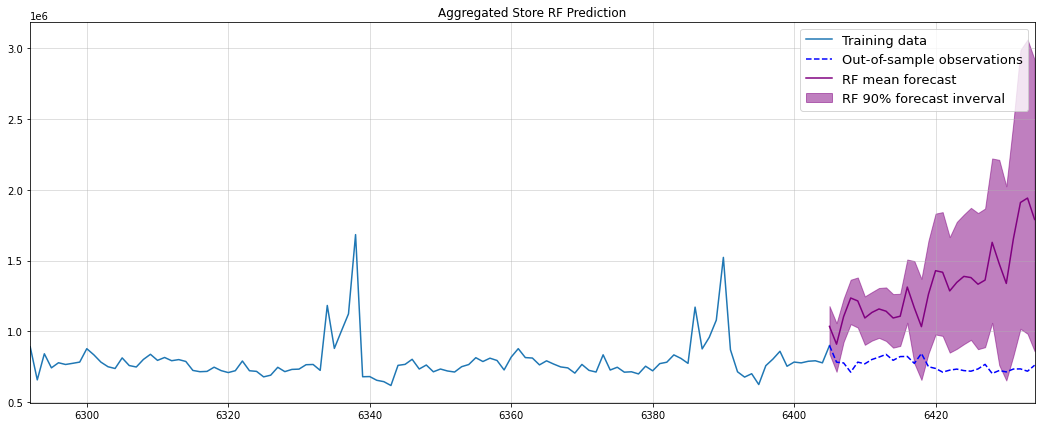

In [ ]:
sum_vals = 0
for i in range(0, 45):
    sum_vals += by_store_preds["preds"][i]

avg_by_store_preds = sum_vals / 45

means_forest_avg = np.mean(avg_by_store_preds,1)
lowers_forest_avg = np.quantile(avg_by_store_preds,0.05,1)
uppers_forest_avg = np.quantile(avg_by_store_preds,0.95,1)

plt.figure(figsize = (18,7))
plt.grid(alpha=0.5)
plt.plot(df_train_s1, label="Training data")
plt.plot(df_test_s1, color = "blue", label = "Out-of-sample observations", ls="dashed")
plt.plot(df_test_s1.index, means_forest_avg,color="purple", label = "RF mean forecast")
plt.fill_between(df_test_s1.index, lowers_forest_avg, uppers_forest_avg, color="purple", alpha=0.5, label = "RF 90% forecast inverval")
plt.legend(fontsize=13)
plt.margins(x=0)
plt.title("Aggregated Store RF Prediction")

In [ ]:
uppers_forest_avg

array([1177742.76503229, 1056973.61797144, 1230649.18667129,
       1364324.45459361, 1379973.07979331, 1246656.20245576,
       1276766.77174386, 1305845.13502705, 1309959.79522859,
       1262653.99697079, 1265015.41838696, 1506688.84673432,
       1495937.4628428 , 1370306.27658559, 1640825.86936652,
       1831044.78817789, 1841736.90479051, 1664952.33120525,
       1772311.71542016, 1824526.84321991, 1871828.36261811,
       1835072.69386077, 1867114.18982578, 2220536.60658335,
       2210732.88130405, 2024066.2489346 , 2474568.59541851,
       2986831.98944308, 3060296.76742924, 2918420.00417988])

The aggregated store model drastically overestimates the test data. This is perhaps because, at an individual store level, ARF is simply not a good model to fit the data; and since there is such variation between the weekly sales of stores as shown in the EDA, it is possible that the model is a worse fit for larger stores, thereby causing systematic overestimation.

Overall, different variations of random forest models fail to outperform even the baseline model. Further investigation in this area may include some variation of the by-store model, if store number is in fact a significant variable; perhaps each store has its own best-depth model, so each would need to be individually hyperparamater tuned. Additionally, it may be the case that expanding the amount of data available could improve the performance of ML-based models; right now, there are only two annual cycles present in the entire dataset, and the test set does not contain one of the cyclical spikes. If there were, say, 50 years of data available, ML-based models like random forest would improve in performance.

## **References**

Hastings, Justine S., and Jesse M. Shapiro. “Mental Accounting and Consumer Choice: Evidence from Commodity Price Shocks.” NBER Working Paper Series, 2012, p. 18248, https://doi.org/10.3386/w18248.

Ganong, Peter Nathan. Essays in Labor and Public Economics. “How does unemployment affect consumer spending?”. ProQuest Dissertations Publishing, 2016.

Parsons, Andrew G. “The Association Between Daily Weather and Daily Shopping Patterns.” Australasian Marketing Journal, vol. 9, no. 2, 2001, pp. 78–84, https://doi.org/10.1016/S1441-3582(01)70177-2. 